In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from scipy.linalg import inv
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("="*80)
print("SIMPLE ML MODEL FOR GEOPOLITICAL PERIOD CLASSIFICATION")
print("="*80)

SIMPLE ML MODEL FOR GEOPOLITICAL PERIOD CLASSIFICATION


In [2]:
# ============================================================================
# DATA LOADING
# ============================================================================

# Load processed features with labels
data_path = Path('data/processed_features_with_labels.csv')
df = pd.read_csv(data_path, parse_dates=['date'])

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())

# Display first few rows
print(f"\n{'='*80}")
print("First 5 rows:")
print(f"{'='*80}")
print(df.head())

Loaded data shape: (610, 34)
Date range: 2024-02-06 01:00:00+00:00 to 2026-01-23 01:00:00+00:00

Label distribution:
label
Normal            376
Post-War Close     51
Post-War Late      52
Pre-War Close      51
Pre-War Early      51
Unlabeled          19
War                10
Name: count, dtype: int64

First 5 rows:
                       date  WTI_price  BRENT_price   label    spread  \
0 2024-02-06 01:00:00+00:00  73.092905    78.529238  Normal  5.436333   
1 2024-02-07 01:00:00+00:00  73.656714    79.122619  Normal  5.465905   
2 2024-02-08 01:00:00+00:00  74.906286    80.498857  Normal  5.592571   
3 2024-02-09 01:00:00+00:00  76.406429    81.895190  Normal  5.488762   
4 2024-02-11 23:00:00+00:00  76.422000    81.985000  Normal  5.563000   

   spread_vol_24h  spread_vol_5d  spread_vol_30d  WTI_return_1d  \
0        0.051554       0.190322        0.233255       0.010507   
1        0.027349       0.206858        0.232128       0.007714   
2        0.055914       0.199626        0.

In [3]:
# ============================================================================
# DATA PREPARATION: TRAIN/TEST SPLIT
# ============================================================================

# Split data: 2024-2025 for training, 2026 for testing
cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')

# Training data: 2024-2025 (labeled data only, exclude 'Unlabeled')
df_train = df[(df['date'] < cutoff_date) & (df['label'] != 'Unlabeled')].copy()
df_test = df[df['date'] >= cutoff_date].copy()

print(f"{'='*80}")
print("TRAIN/TEST SPLIT")
print(f"{'='*80}")
print(f"\nTraining data (2024-2025, labeled only):")
print(f"  Shape: {df_train.shape}")
print(f"  Date range: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"  Label distribution:")
print(df_train['label'].value_counts().sort_index())

print(f"\nTest data (2026, unlabeled):")
print(f"  Shape: {df_test.shape}")
print(f"  Date range: {df_test['date'].min()} to {df_test['date'].max()}")
print(f"  Label distribution:")
print(df_test['label'].value_counts().sort_index())

# Get global z-score features (10 features)
zscore_global_features = [col for col in df.columns if col.endswith('_zscore_global')]
print(f"\n{'='*80}")
print(f"FEATURES FOR MODELING ({len(zscore_global_features)} global z-scores)")
print(f"{'='*80}")
for feat in sorted(zscore_global_features):
    print(f"  - {feat}")

# Prepare features and labels
X_train = df_train[zscore_global_features].values
y_train = df_train['label'].values

X_test = df_test[zscore_global_features].values
y_test = df_test['label'].values

# Check for NaN values
print(f"\n{'='*80}")
print("DATA QUALITY CHECK")
print(f"{'='*80}")
print(f"Training data - NaN count: {np.isnan(X_train).sum()}")
print(f"Test data - NaN count: {np.isnan(X_test).sum()}")

# Remove rows with NaN if any
train_valid_mask = ~np.isnan(X_train).any(axis=1)
test_valid_mask = ~np.isnan(X_test).any(axis=1)

X_train = X_train[train_valid_mask]
y_train = y_train[train_valid_mask]
X_test = X_test[test_valid_mask]
y_test = y_test[test_valid_mask]

print(f"\nAfter removing NaN:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")

# Encode labels to numeric (only for training - test set is unlabeled)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

print(f"\nLabel encoding (training classes):")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {i}")

print(f"\n⚠️  Note: Test set (2026) is unlabeled - we can only make predictions, not evaluate accuracy.")

TRAIN/TEST SPLIT

Training data (2024-2025, labeled only):
  Shape: (591, 34)
  Date range: 2024-02-06 01:00:00+00:00 to 2025-12-31 01:00:00+00:00
  Label distribution:
label
Normal            376
Post-War Close     51
Post-War Late      52
Pre-War Close      51
Pre-War Early      51
War                10
Name: count, dtype: int64

Test data (2026, unlabeled):
  Shape: (19, 34)
  Date range: 2026-01-02 01:00:00+00:00 to 2026-01-23 01:00:00+00:00
  Label distribution:
label
Unlabeled    19
Name: count, dtype: int64

FEATURES FOR MODELING (10 global z-scores)
  - WTI_price_vol_24h_zscore_global
  - WTI_price_vol_30d_zscore_global
  - WTI_price_vol_5d_zscore_global
  - WTI_return_1d_zscore_global
  - WTI_return_30d_zscore_global
  - WTI_return_5d_zscore_global
  - spread_vol_24h_zscore_global
  - spread_vol_30d_zscore_global
  - spread_vol_5d_zscore_global
  - spread_zscore_global

DATA QUALITY CHECK
Training data - NaN count: 0
Test data - NaN count: 0

After removing NaN:
  Training sam

In [4]:
# ============================================================================
# MODEL TRAINING: MULTIPLE SIMPLE MODELS
# ============================================================================

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs'),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True)
}

trained_models = {}
train_scores = {}
test_scores = {}

print(f"{'='*80}")
print("TRAINING MODELS")
print(f"{'='*80}")

for name, model in models.items():
    print(f"\n{'─'*80}")
    print(f"Training {name}...")
    print(f"{'─'*80}")
    
    # Train model
    model.fit(X_train, y_train_encoded)
    trained_models[name] = model
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)  # Predictions for unlabeled test set
    
    # Calculate accuracy (only for training - test set is unlabeled)
    train_acc = accuracy_score(y_train_encoded, y_train_pred)
    
    train_scores[name] = train_acc
    test_scores[name] = None  # Cannot calculate test accuracy (unlabeled data)
    
    print(f"  Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Test Set: {len(X_test)} predictions made (unlabeled - cannot evaluate accuracy)")
    
    # Classification report (only for training set)
    print(f"\n  Classification Report (Training Set):")
    print(classification_report(
        y_train_encoded, 
        y_train_pred, 
        target_names=label_encoder.classes_,
        digits=3
    ))

print(f"\n{'='*80}")
print("MODEL COMPARISON")
print(f"{'='*80}")
print(f"\n{'Model':<25} {'Train Accuracy':<20} {'Test Set Size':<20}")
print(f"{'-'*65}")
for name in models.keys():
    test_size = len(X_test) if test_scores[name] is None else "N/A"
    print(f"{name:<25} {train_scores[name]:<20.4f} {str(test_size):<20}")
print(f"\n⚠️  Note: Test set (2026) is unlabeled - predictions made but accuracy cannot be calculated.")

TRAINING MODELS

────────────────────────────────────────────────────────────────────────────────
Training Random Forest...
────────────────────────────────────────────────────────────────────────────────
  Training Accuracy: 0.9915 (99.15%)
  Test Set: 19 predictions made (unlabeled - cannot evaluate accuracy)

  Classification Report (Training Set):
                precision    recall  f1-score   support

        Normal      0.987     1.000     0.993       376
Post-War Close      1.000     0.961     0.980        51
 Post-War Late      1.000     1.000     1.000        52
 Pre-War Close      1.000     1.000     1.000        51
 Pre-War Early      1.000     0.941     0.970        51
           War      1.000     1.000     1.000        10

      accuracy                          0.992       591
     macro avg      0.998     0.984     0.991       591
  weighted avg      0.992     0.992     0.991       591


────────────────────────────────────────────────────────────────────────────────
T

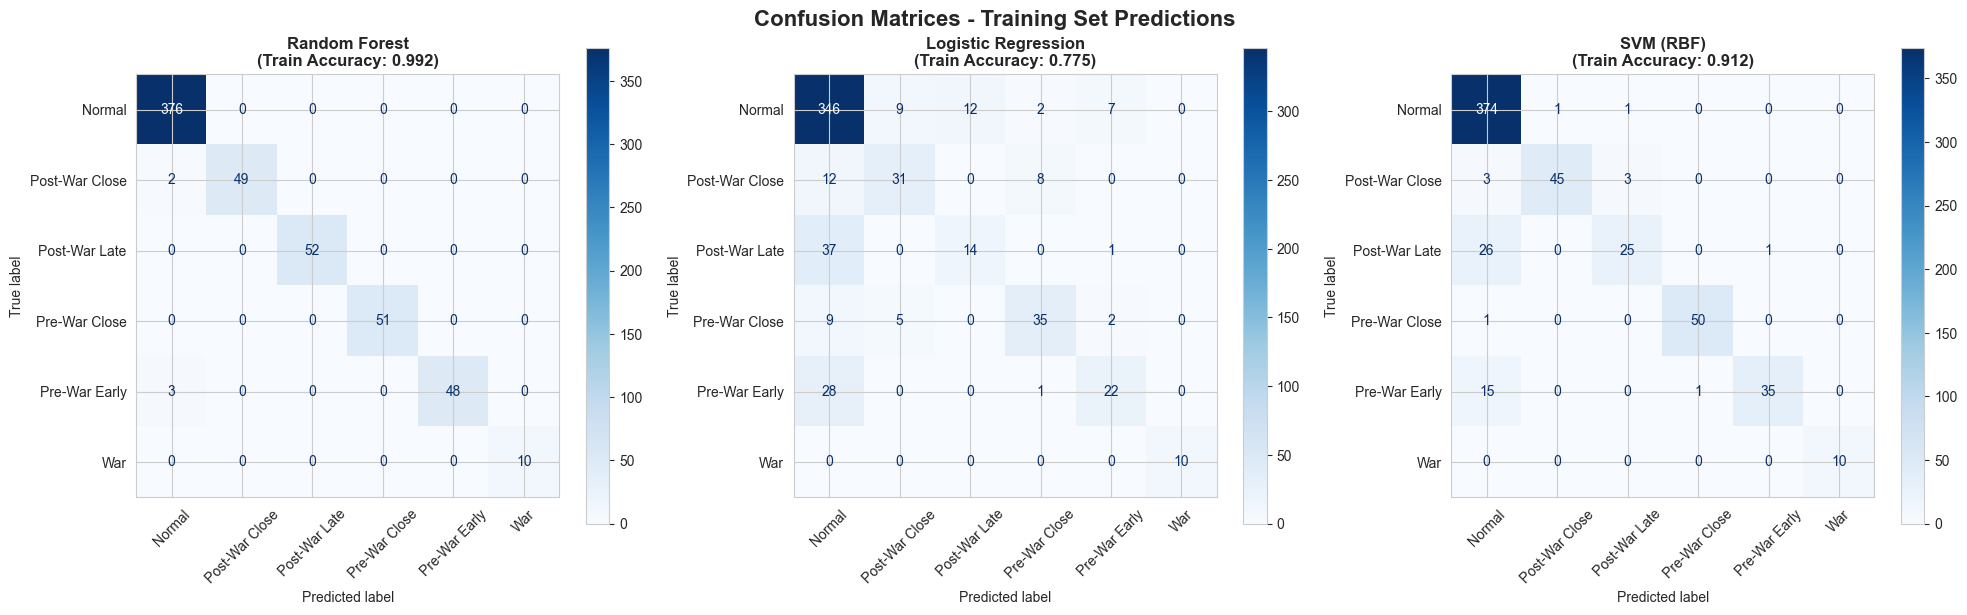


⚠️  Note: Test set (2026) is unlabeled - cannot create confusion matrix.


In [5]:
# ============================================================================
# VISUALIZATION: CONFUSION MATRICES (Training Set Only)
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrices - Training Set Predictions', fontsize=16, fontweight='bold')

for idx, (name, model) in enumerate(trained_models.items()):
    ax = axes[idx]
    
    # Get predictions for training set
    y_train_pred = model.predict(X_train)
    
    # Confusion matrix
    cm = confusion_matrix(y_train_encoded, y_train_pred)
    
    # Display
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_
    )
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{name}\n(Train Accuracy: {train_scores[name]:.3f})', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

print(f"\n⚠️  Note: Test set (2026) is unlabeled - cannot create confusion matrix.")

FEATURE IMPORTANCE (Random Forest)
                        feature  importance
WTI_price_vol_30d_zscore_global    0.205815
           spread_zscore_global    0.193773
   spread_vol_30d_zscore_global    0.192309
   WTI_return_30d_zscore_global    0.091870
    spread_vol_5d_zscore_global    0.083491
 WTI_price_vol_5d_zscore_global    0.072493
   spread_vol_24h_zscore_global    0.052532
    WTI_return_5d_zscore_global    0.042437
WTI_price_vol_24h_zscore_global    0.041006
    WTI_return_1d_zscore_global    0.024274


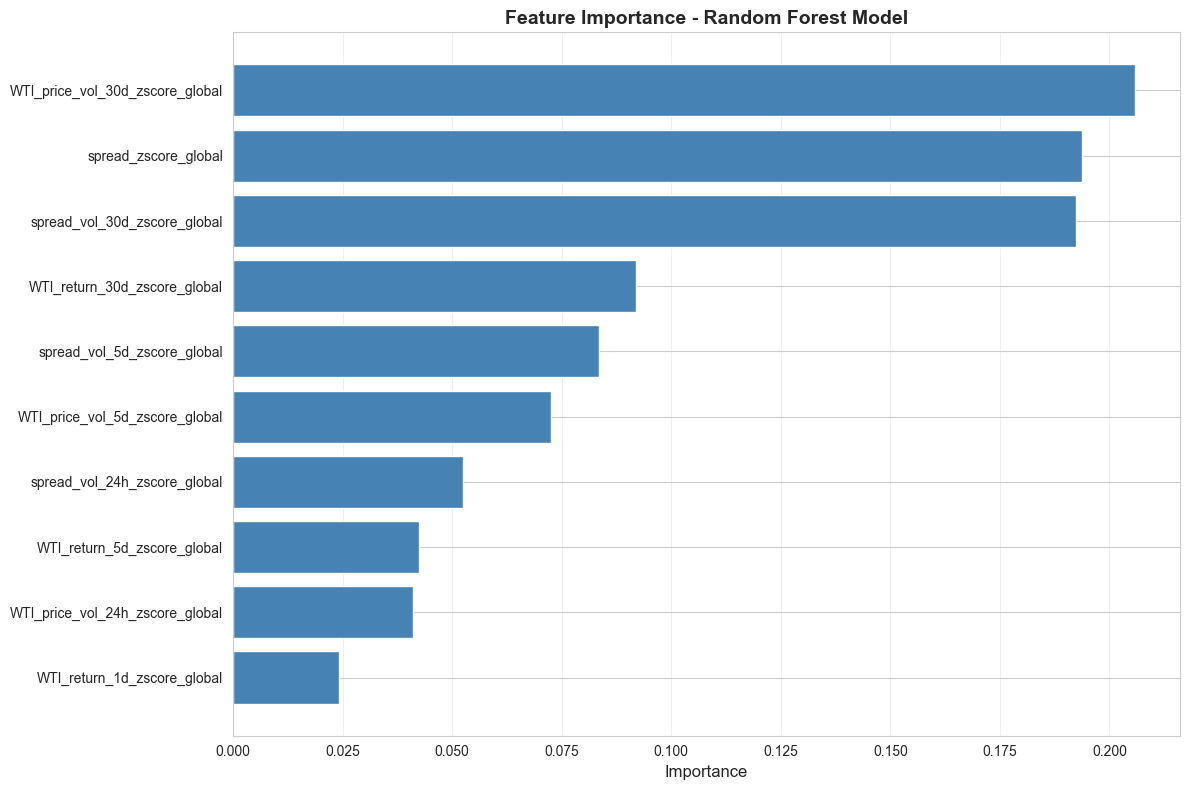

In [6]:
# ============================================================================
# FEATURE IMPORTANCE (Random Forest)
# ============================================================================

if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    feature_importance = rf_model.feature_importances_
    
    # Create DataFrame for easier visualization
    importance_df = pd.DataFrame({
        'feature': zscore_global_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"{'='*80}")
    print("FEATURE IMPORTANCE (Random Forest)")
    print(f"{'='*80}")
    print(importance_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(importance_df)), importance_df['importance'], color='steelblue')
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title('Feature Importance - Random Forest Model', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

PREDICTIONS FOR ALL MODELS (Test Set - 2026)

────────────────────────────────────────────────────────────────────────────────
Model: Random Forest
────────────────────────────────────────────────────────────────────────────────
  Total predictions: 19
  Predicted label distribution:
    Normal: 19 (100.0%)

────────────────────────────────────────────────────────────────────────────────
Model: Logistic Regression
────────────────────────────────────────────────────────────────────────────────
  Total predictions: 19
  Predicted label distribution:
    Normal: 19 (100.0%)

────────────────────────────────────────────────────────────────────────────────
Model: SVM (RBF)
────────────────────────────────────────────────────────────────────────────────
  Total predictions: 19
  Predicted label distribution:
    Normal: 19 (100.0%)


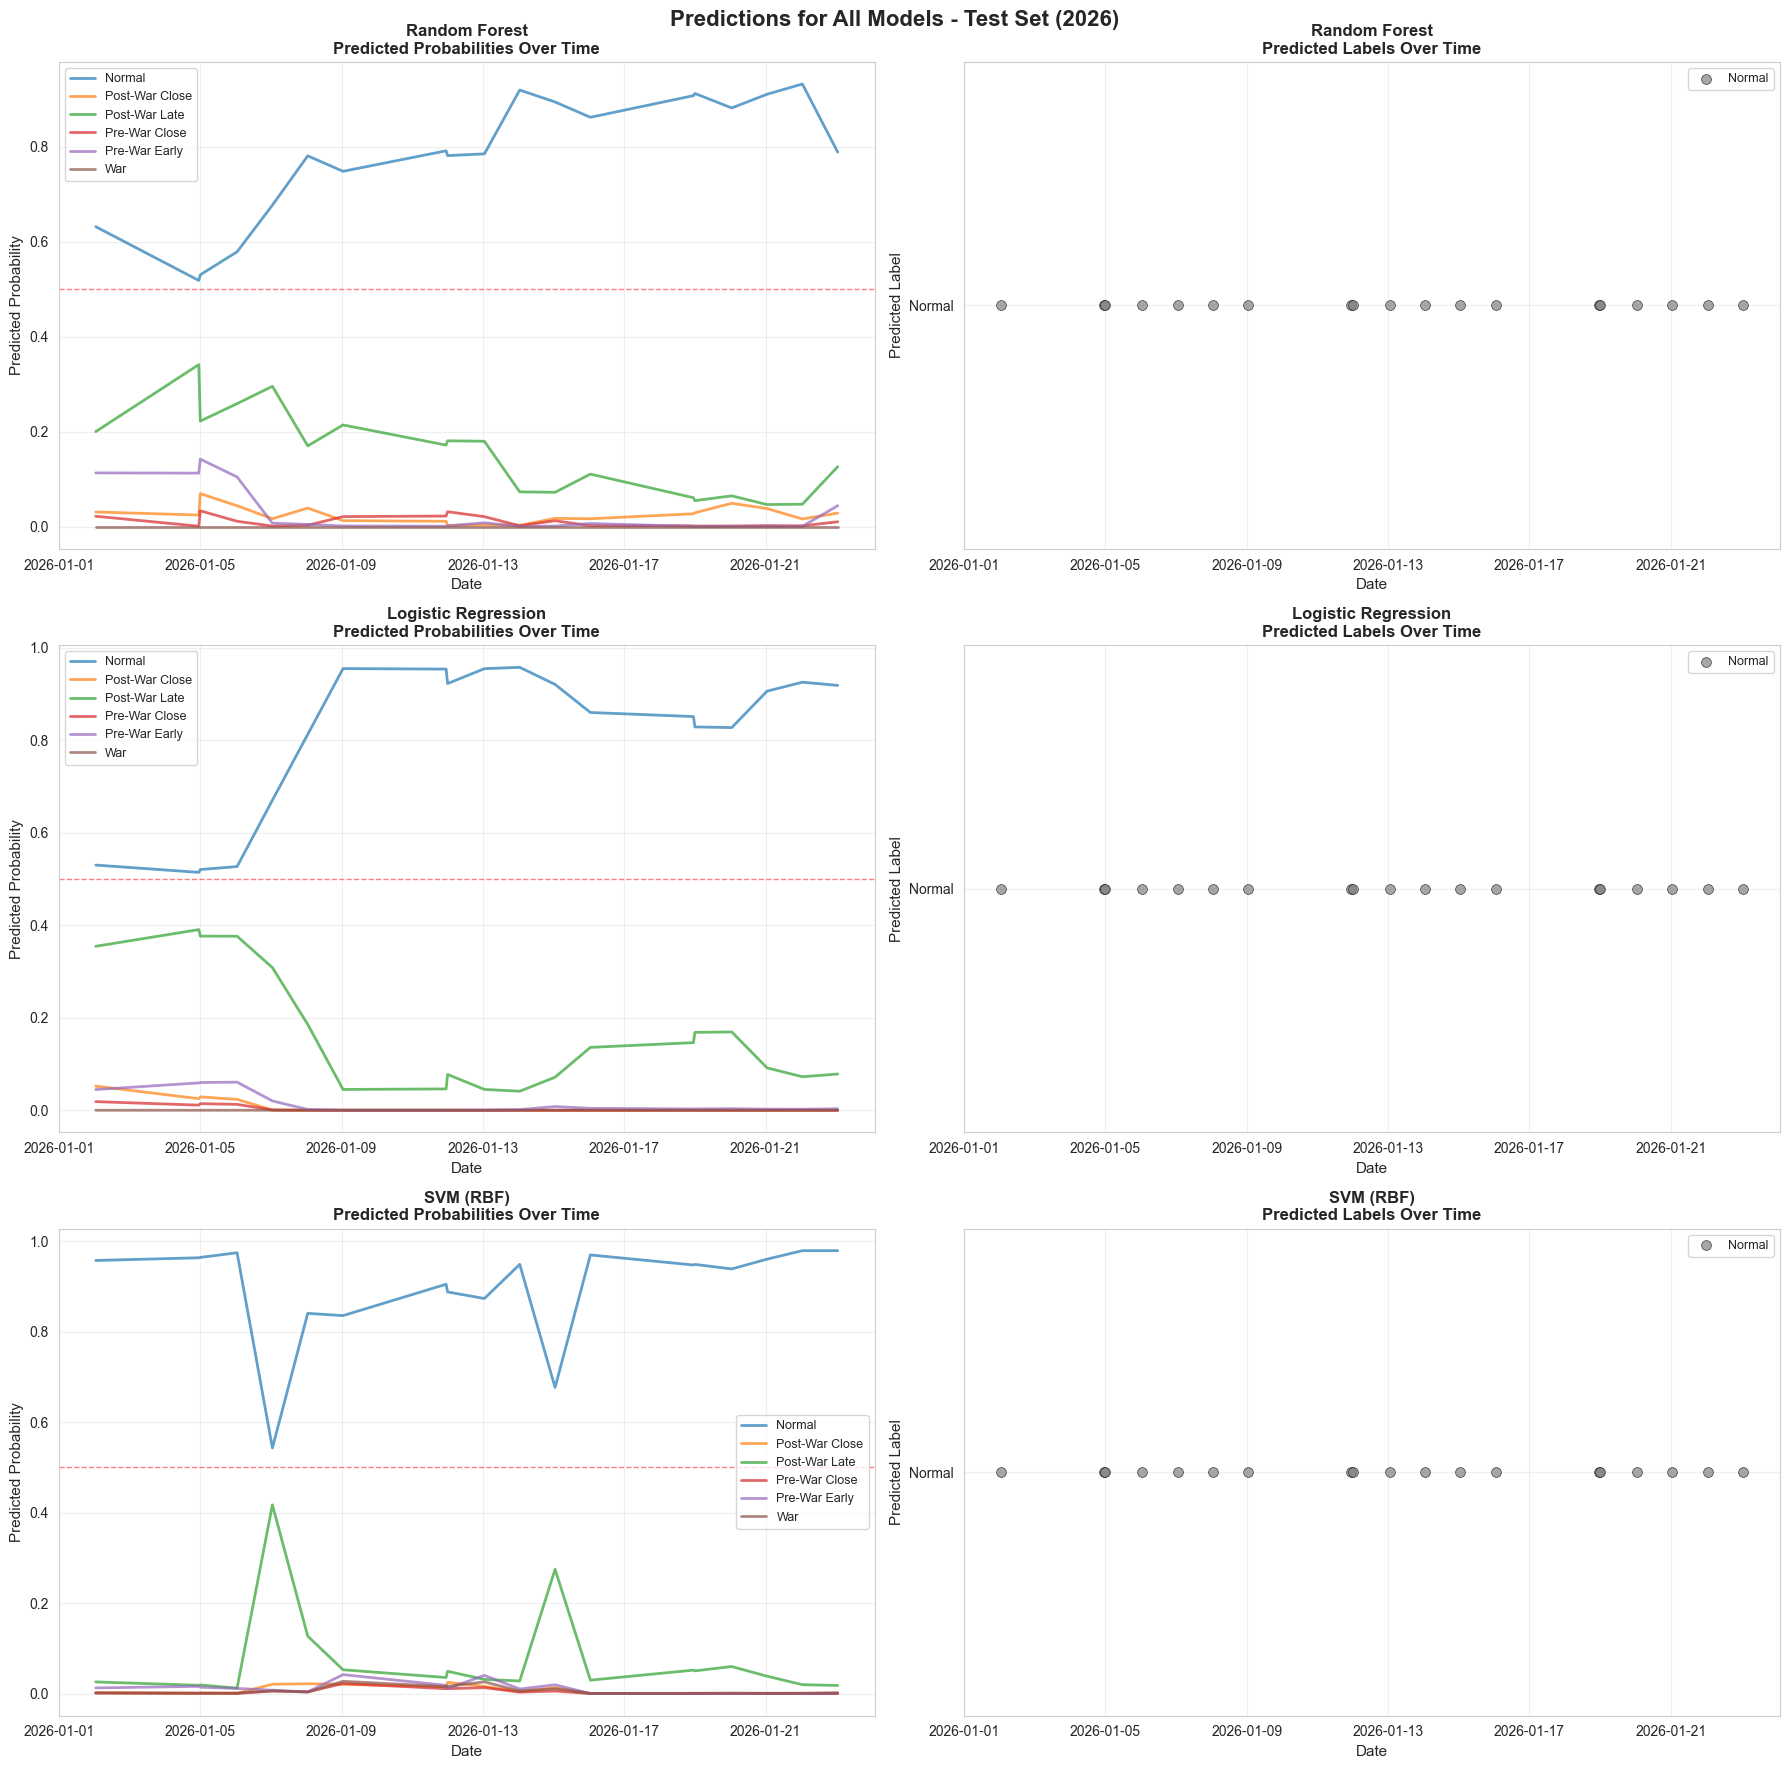


PREDICTION COMPARISON ACROSS ALL MODELS

Predicted Label Percentages by Model:
Model           Logistic Regression  Random Forest  SVM (RBF)
Label                                                        
Normal                        100.0          100.0      100.0
Post-War Close                  0.0            0.0        0.0
Post-War Late                   0.0            0.0        0.0
Pre-War Close                   0.0            0.0        0.0
Pre-War Early                   0.0            0.0        0.0
War                             0.0            0.0        0.0


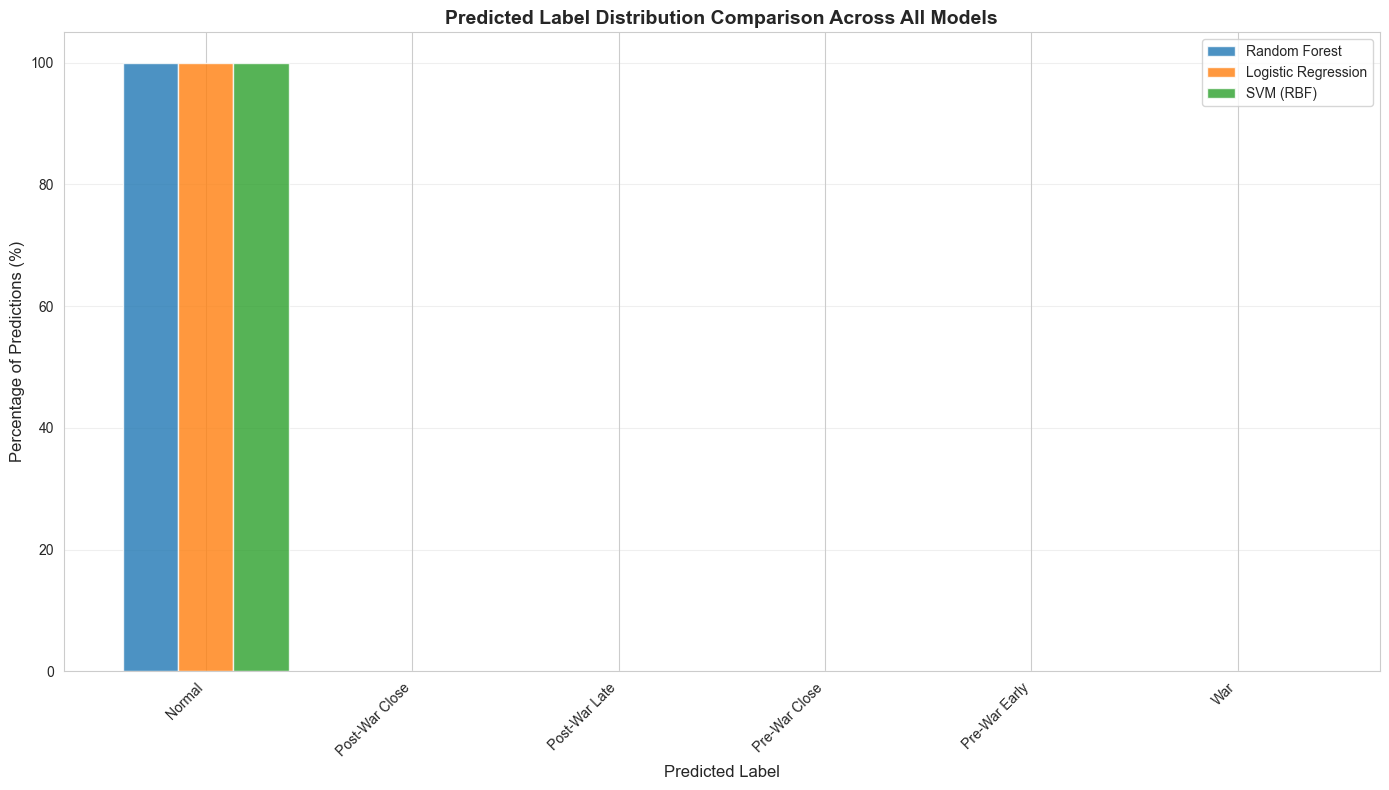


PRE-WAR RISK ASSESSMENT

Random Forest:
  Average pre-war probability: 0.0409 (4.09%)
  Max pre-war probability: 0.1767 (17.67%)
  Days with pre-war prob > 0.5: 0 / 19

Logistic Regression:
  Average pre-war probability: 0.0176 (1.76%)
  Max pre-war probability: 0.0743 (7.43%)
  Days with pre-war prob > 0.5: 0 / 19

SVM (RBF):
  Average pre-war probability: 0.0152 (1.52%)
  Max pre-war probability: 0.0643 (6.43%)
  Days with pre-war prob > 0.5: 0 / 19

────────────────────────────────────────────────────────────────────────────────
MAXIMUM PRE-WAR RISK (Highest probability across all models per day):
────────────────────────────────────────────────────────────────────────────────
  Average max pre-war probability: 0.0461 (4.61%)
  Maximum pre-war probability: 0.1767 (17.67%)
  Days with max pre-war prob > 0.3: 0 / 19
  Days with max pre-war prob > 0.5: 0 / 19
  Days with max pre-war prob > 0.7: 0 / 19


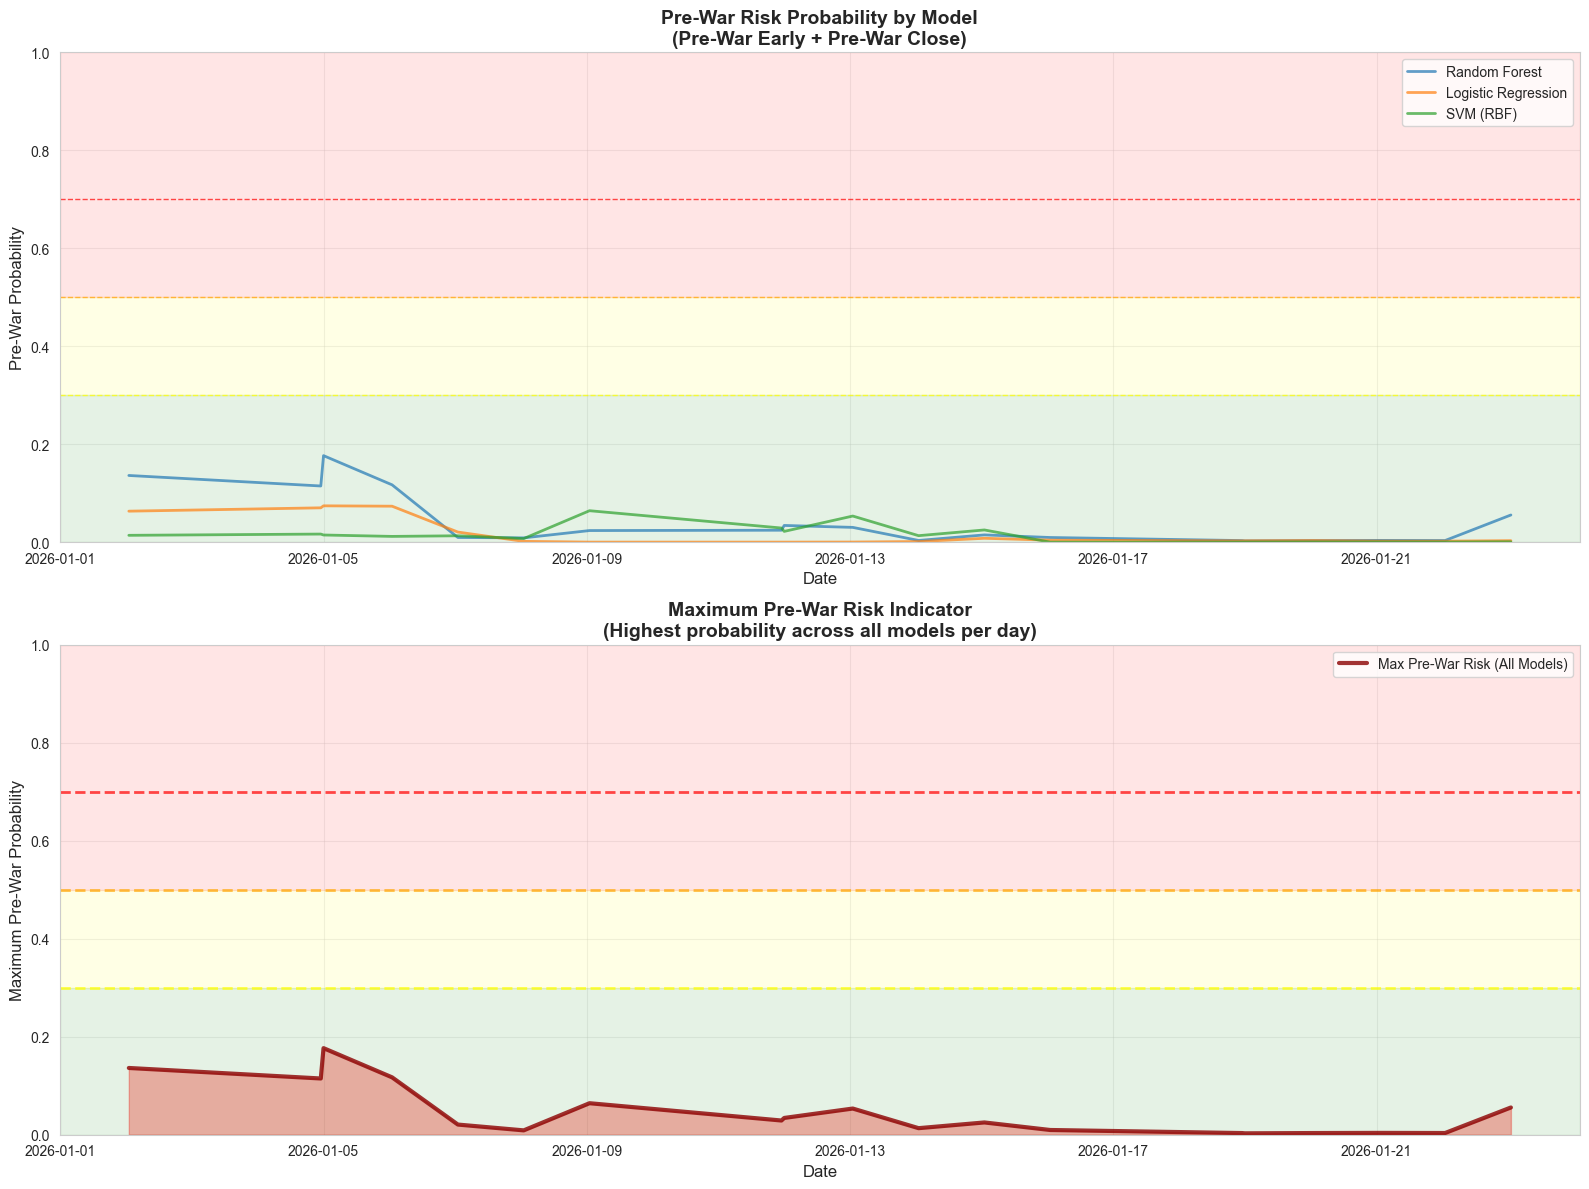


────────────────────────────────────────────────────────────────────────────────
No high-risk days detected (max pre-war probability > 0.5)

ALL MODEL PREDICTIONS COMPLETE

Predictions stored in 'all_predictions' dictionary:
  - Random Forest: all_predictions['Random Forest']
  - Logistic Regression: all_predictions['Logistic Regression']
  - SVM (RBF): all_predictions['SVM (RBF)']

Pre-war risk probabilities stored in 'pre_war_risk' dictionary
Maximum pre-war risk DataFrame: 'risk_df'


In [7]:
# ============================================================================
# PREDICTIONS FOR ALL MODELS - AUTOMATIC
# ============================================================================

print(f"{'='*80}")
print("PREDICTIONS FOR ALL MODELS (Test Set - 2026)")
print(f"{'='*80}")

# Store predictions for all models
all_predictions = {}

# Label colors for visualization
label_colors = {
    'Normal': 'gray',
    'Pre-War Early': 'lightblue',
    'Pre-War Close': 'orange',
    'War': 'red',
    'Post-War Close': 'purple',
    'Post-War Late': 'green',
    'Unlabeled': 'black'
}

# Get base results DataFrame
results_base = df_test[test_valid_mask].copy()

# Loop through all trained models automatically
for model_name, model in trained_models.items():
    print(f"\n{'─'*80}")
    print(f"Model: {model_name}")
    print(f"{'─'*80}")
    
    # Get predictions and probabilities for test set
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)
    
    # Create results DataFrame for this model
    results_df = results_base.copy()
    results_df['predicted_label'] = label_encoder.inverse_transform(y_test_pred)
    results_df['predicted_label_encoded'] = y_test_pred
    
    # Add probability for each class
    for i, label in enumerate(label_encoder.classes_):
        results_df[f'prob_{label}'] = y_test_proba[:, i]
    
    # Store predictions
    all_predictions[model_name] = results_df
    
    # Print summary
    print(f"  Total predictions: {len(results_df)}")
    print(f"  Predicted label distribution:")
    pred_dist = results_df['predicted_label'].value_counts().sort_index()
    for label, count in pred_dist.items():
        print(f"    {label}: {count} ({count/len(results_df)*100:.1f}%)")

# ============================================================================
# VISUALIZATION: PREDICTED PROBABILITIES FOR ALL MODELS
# ============================================================================

n_models = len(trained_models)
fig, axes = plt.subplots(n_models, 2, figsize=(18, 6*n_models))
fig.suptitle('Predictions for All Models - Test Set (2026)', fontsize=16, fontweight='bold')

if n_models == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, results_df) in enumerate(all_predictions.items()):
    # Plot 1: Predicted probabilities over time
    ax = axes[idx, 0]
    for label in label_encoder.classes_:
        if label != 'Unlabeled':  # Skip unlabeled since it's not in training
            ax.plot(results_df['date'], results_df[f'prob_{label}'], 
                   label=label, linewidth=2, alpha=0.7)
    
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Predicted Probability', fontsize=11)
    ax.set_title(f'{model_name}\nPredicted Probabilities Over Time', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    # Plot 2: Most likely predicted class over time
    ax = axes[idx, 1]
    for label in label_encoder.classes_:
        mask = results_df['predicted_label'] == label
        if mask.sum() > 0:
            ax.scatter(results_df.loc[mask, 'date'], 
                      [label] * mask.sum(),
                      c=label_colors.get(label, 'black'),
                      label=label, alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Predicted Label', fontsize=11)
    ax.set_title(f'{model_name}\nPredicted Labels Over Time', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# COMPARISON: PREDICTED LABEL DISTRIBUTIONS ACROSS MODELS
# ============================================================================

print(f"\n{'='*80}")
print("PREDICTION COMPARISON ACROSS ALL MODELS")
print(f"{'='*80}")

# Create comparison DataFrame
comparison_data = []
for model_name, results_df in all_predictions.items():
    pred_dist = results_df['predicted_label'].value_counts()
    for label in label_encoder.classes_:
        count = pred_dist.get(label, 0)
        pct = count / len(results_df) * 100
        comparison_data.append({
            'Model': model_name,
            'Label': label,
            'Count': count,
            'Percentage': pct
        })

comparison_df = pd.DataFrame(comparison_data)

# Pivot for better visualization
comparison_pivot = comparison_df.pivot(index='Label', columns='Model', values='Percentage')
print("\nPredicted Label Percentages by Model:")
print(comparison_pivot.round(1).to_string())

# Visualize comparison
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(label_encoder.classes_))
width = 0.8 / len(trained_models)

for i, model_name in enumerate(trained_models.keys()):
    model_data = comparison_df[comparison_df['Model'] == model_name]
    percentages = [model_data[model_data['Label'] == label]['Percentage'].values[0] 
                  if len(model_data[model_data['Label'] == label]) > 0 else 0 
                  for label in label_encoder.classes_]
    ax.bar(x + i*width, percentages, width, label=model_name, alpha=0.8)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('Percentage of Predictions (%)', fontsize=12)
ax.set_title('Predicted Label Distribution Comparison Across All Models', 
            fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(trained_models) - 1) / 2)
ax.set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ============================================================================
# PRE-WAR RISK ASSESSMENT: MAXIMUM PROBABILITY ACROSS ALL MODELS
# ============================================================================

print(f"\n{'='*80}")
print("PRE-WAR RISK ASSESSMENT")
print(f"{'='*80}")

# Calculate pre-war probability for each model (Pre-War Early + Pre-War Close)
pre_war_risk = {}

for model_name, results_df in all_predictions.items():
    # Sum of Pre-War Early and Pre-War Close probabilities
    pre_war_prob = results_df['prob_Pre-War Early'] + results_df['prob_Pre-War Close']
    pre_war_risk[model_name] = pre_war_prob
    print(f"\n{model_name}:")
    print(f"  Average pre-war probability: {pre_war_prob.mean():.4f} ({pre_war_prob.mean()*100:.2f}%)")
    print(f"  Max pre-war probability: {pre_war_prob.max():.4f} ({pre_war_prob.max()*100:.2f}%)")
    print(f"  Days with pre-war prob > 0.5: {(pre_war_prob > 0.5).sum()} / {len(pre_war_prob)}")

# Calculate maximum pre-war probability across all models for each day
# Use a more robust approach: create DataFrame with dates and align all models

# Start with dates from the first model's predictions
first_model_name = list(all_predictions.keys())[0]
risk_df = pd.DataFrame({
    'date': all_predictions[first_model_name]['date'].values
})

# Add pre-war probabilities from each model
for model_name, pre_war_prob in pre_war_risk.items():
    # Create a temporary DataFrame to merge
    temp_df = pd.DataFrame({
        'date': all_predictions[model_name]['date'].values,
        f'{model_name}_pre_war': pre_war_prob.values
    })
    # Merge on date
    risk_df = risk_df.merge(temp_df, on='date', how='outer')

# Sort by date
risk_df = risk_df.sort_values('date').reset_index(drop=True)

# Calculate maximum across all model columns (excluding 'date')
model_cols = [col for col in risk_df.columns if col != 'date']
risk_df['max_pre_war_probability'] = risk_df[model_cols].max(axis=1)

# Extract the maximum pre-war risk as a Series for statistics
max_pre_war_risk = risk_df['max_pre_war_probability']

print(f"\n{'─'*80}")
print("MAXIMUM PRE-WAR RISK (Highest probability across all models per day):")
print(f"{'─'*80}")
print(f"  Average max pre-war probability: {max_pre_war_risk.mean():.4f} ({max_pre_war_risk.mean()*100:.2f}%)")
print(f"  Maximum pre-war probability: {max_pre_war_risk.max():.4f} ({max_pre_war_risk.max()*100:.2f}%)")
print(f"  Days with max pre-war prob > 0.3: {(max_pre_war_risk > 0.3).sum()} / {len(max_pre_war_risk)}")
print(f"  Days with max pre-war prob > 0.5: {(max_pre_war_risk > 0.5).sum()} / {len(max_pre_war_risk)}")
print(f"  Days with max pre-war prob > 0.7: {(max_pre_war_risk > 0.7).sum()} / {len(max_pre_war_risk)}")

# Visualize pre-war risk
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Individual model pre-war probabilities
ax = axes[0]
for model_name, pre_war_prob in pre_war_risk.items():
    ax.plot(all_predictions[model_name]['date'], pre_war_prob, 
           label=f'{model_name}', linewidth=2, alpha=0.7)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Pre-War Probability', fontsize=12)
ax.set_title('Pre-War Risk Probability by Model\n(Pre-War Early + Pre-War Close)', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0.3, color='yellow', linestyle='--', alpha=0.7, linewidth=1, label='Low Risk (0.3)')
ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, linewidth=1, label='Medium Risk (0.5)')
ax.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, linewidth=1, label='High Risk (0.7)')
ax.axhspan(0, 0.3, alpha=0.1, color='green', label='Low Risk Zone')
ax.axhspan(0.3, 0.5, alpha=0.1, color='yellow', label='Medium Risk Zone')
ax.axhspan(0.5, 1.0, alpha=0.1, color='red', label='High Risk Zone')
ax.set_ylim([0, 1.0])

# Plot 2: Maximum pre-war probability across all models (risk indicator)
ax = axes[1]
ax.plot(risk_df['date'], risk_df['max_pre_war_probability'], 
       linewidth=3, color='darkred', alpha=0.8, label='Max Pre-War Risk (All Models)')
ax.fill_between(risk_df['date'], 0, risk_df['max_pre_war_probability'], 
               alpha=0.3, color='red')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Maximum Pre-War Probability', fontsize=12)
ax.set_title('Maximum Pre-War Risk Indicator\n(Highest probability across all models per day)', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0.3, color='yellow', linestyle='--', alpha=0.7, linewidth=2, label='Low Risk Threshold (0.3)')
ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Medium Risk Threshold (0.5)')
ax.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, linewidth=2, label='High Risk Threshold (0.7)')
ax.set_ylim([0, 1.0])

# Add risk zone shading
ax.axhspan(0, 0.3, alpha=0.1, color='green')
ax.axhspan(0.3, 0.5, alpha=0.1, color='yellow')
ax.axhspan(0.5, 1.0, alpha=0.1, color='red')

plt.tight_layout()
plt.show()

# Display high-risk days
high_risk_days = risk_df[risk_df['max_pre_war_probability'] > 0.5].sort_values('max_pre_war_probability', ascending=False)
if len(high_risk_days) > 0:
    print(f"\n{'─'*80}")
    print("HIGH RISK DAYS (Max Pre-War Probability > 0.5):")
    print(f"{'─'*80}")
    for idx, row in high_risk_days.iterrows():
        print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['max_pre_war_probability']:.4f} ({row['max_pre_war_probability']*100:.2f}%)")
else:
    print(f"\n{'─'*80}")
    print("No high-risk days detected (max pre-war probability > 0.5)")

print(f"\n{'='*80}")
print("ALL MODEL PREDICTIONS COMPLETE")
print(f"{'='*80}")
print(f"\nPredictions stored in 'all_predictions' dictionary:")
for model_name in all_predictions.keys():
    print(f"  - {model_name}: all_predictions['{model_name}']")
print(f"\nPre-war risk probabilities stored in 'pre_war_risk' dictionary")
print(f"Maximum pre-war risk DataFrame: 'risk_df'")

MAHALANOBIS DISTANCE ANALYSIS

Using Normal + Post-War Late (stable periods) for Mahalanobis distance baseline
  Baseline samples: 428 / 591 total training samples
  Baseline labels: {'Normal': 376, 'Post-War Late': 52}

Mahalanobis Distance Statistics:
  Mean distance: 3.2354
  Median distance: 2.6150
  Std distance: 1.1473
  Min distance: 1.9460
  Max distance: 5.3454

Training Data Thresholds:
  95th percentile: 4.7437
  99th percentile: 5.9025

Test Data Anomaly Detection:
  Points above 95th percentile: 4 / 19 (21.1%)
  Points above 99th percentile: 0 / 19 (0.0%)


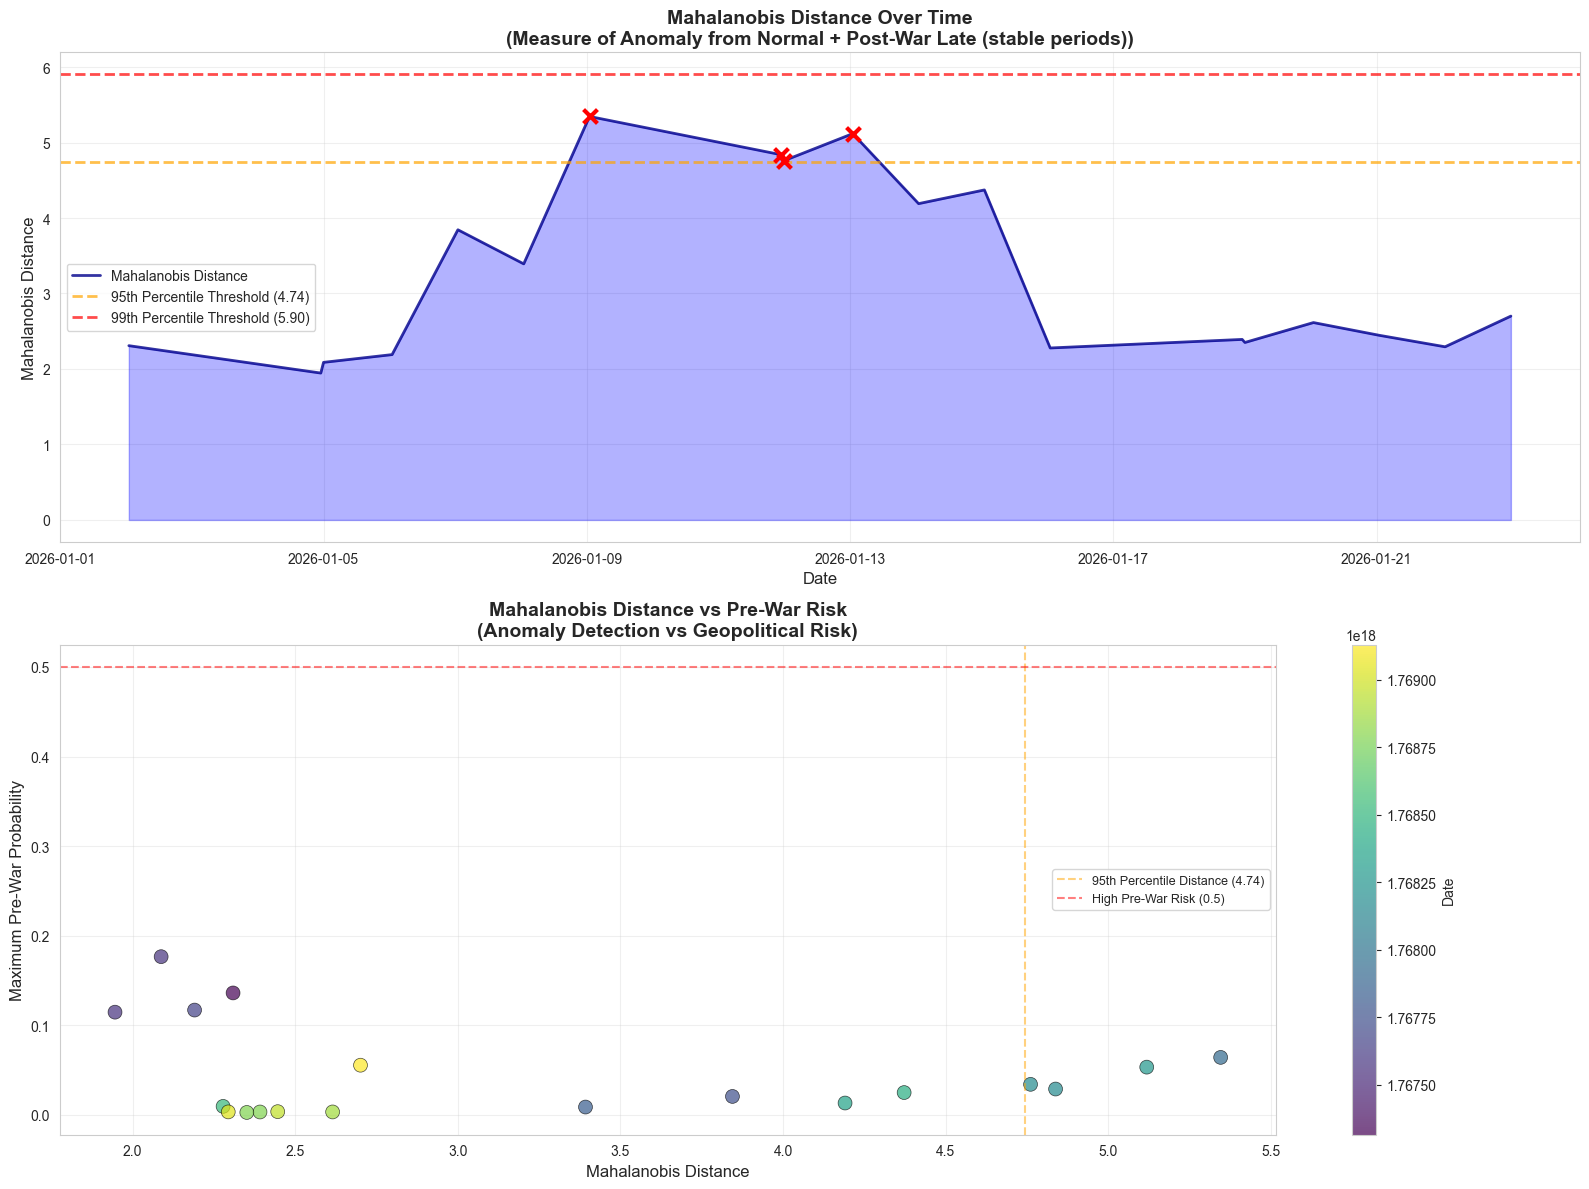


────────────────────────────────────────────────────────────────────────────────
PRE-WAR PERIODS MAHALANOBIS DISTANCE ANALYSIS
────────────────────────────────────────────────────────────────────────────────

Pre-War Period Statistics:
  Pre-War Early:
    Count: 51 days
    Mean Mahalanobis distance: 4.2259
    Max Mahalanobis distance: 11.4473
    Days above 95th percentile: 14 / 51
  Pre-War Close:
    Count: 51 days
    Mean Mahalanobis distance: 4.3885
    Max Mahalanobis distance: 6.4112
    Days above 95th percentile: 17 / 51

Current Data (2026) Statistics:
    Count: 19 days
    Mean Mahalanobis distance: 3.2354
    Max Mahalanobis distance: 5.3454
    Days above 95th percentile: 4 / 19


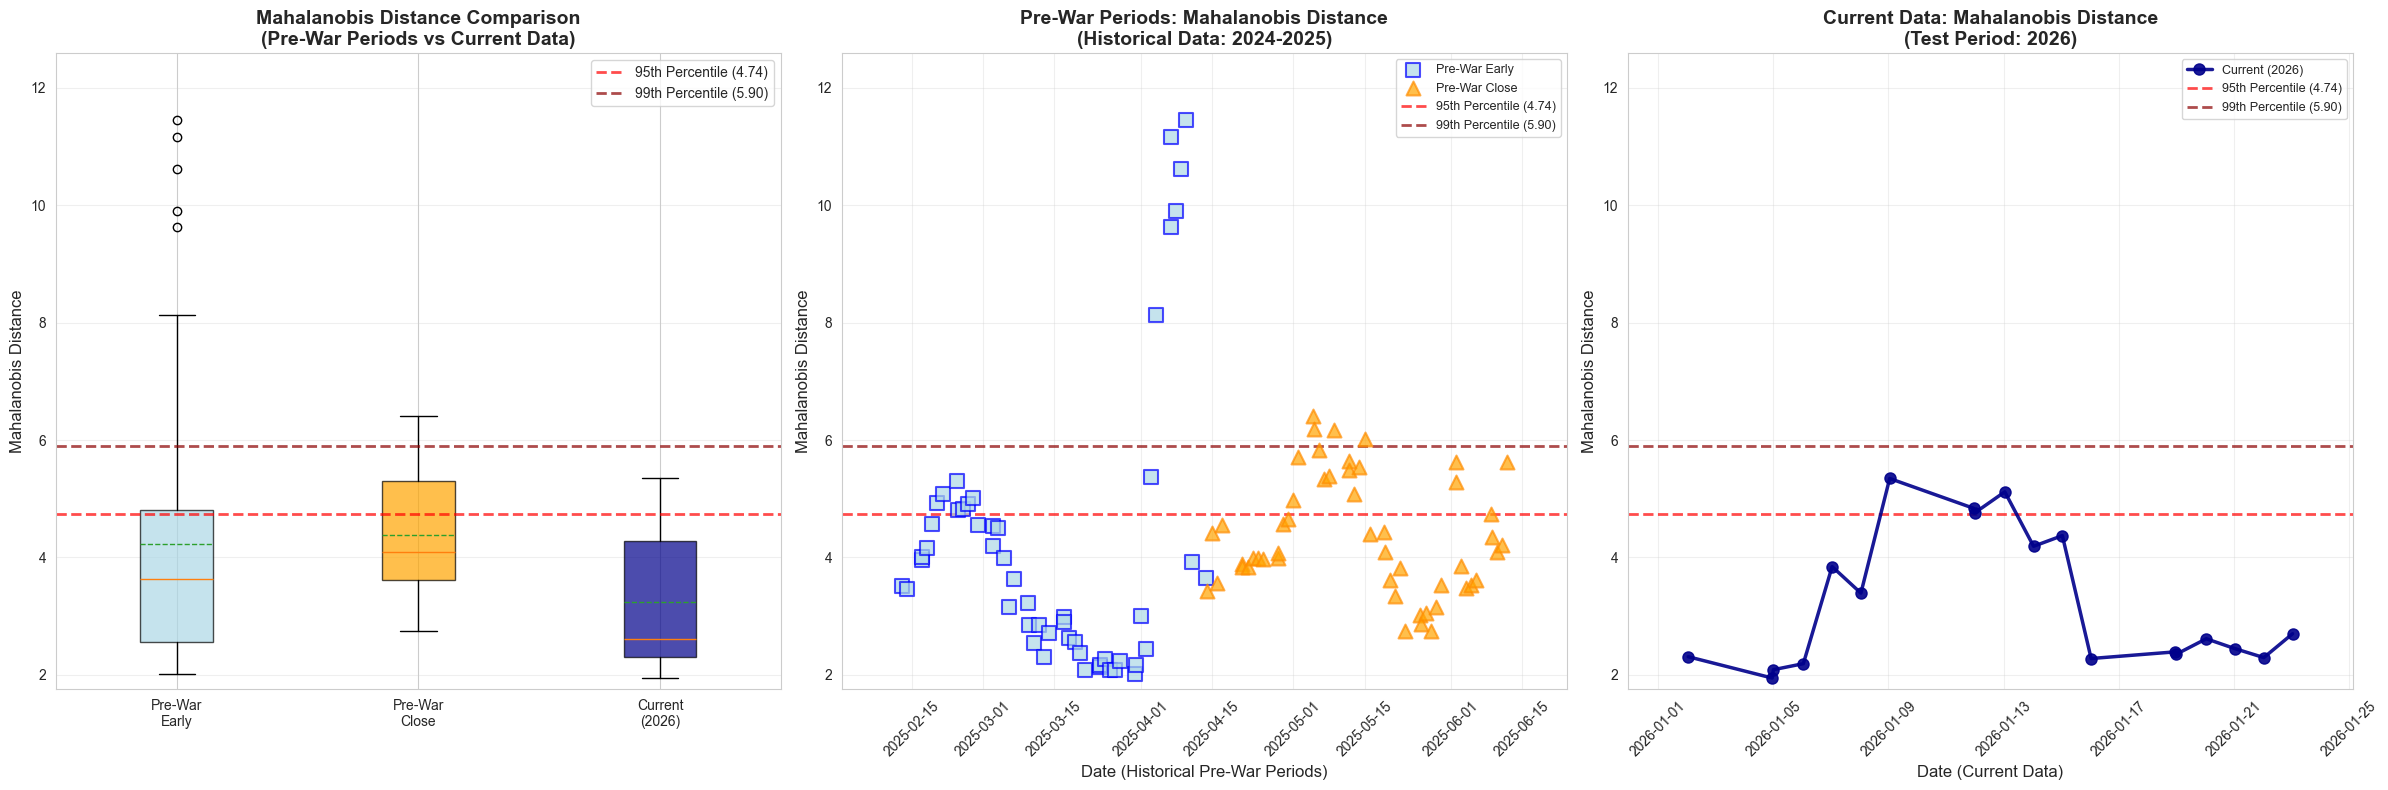


────────────────────────────────────────────────────────────────────────────────
STATISTICAL COMPARISON
────────────────────────────────────────────────────────────────────────────────
Current (2026) vs Pre-War Early:
  Mean difference: -0.9905
  Current mean is lower than Pre-War Early

Current (2026) vs Pre-War Close:
  Mean difference: -1.1531
  Current mean is lower than Pre-War Close

────────────────────────────────────────────────────────────────────────────────
MOST ANOMALOUS DAYS (Highest Mahalanobis Distance):
────────────────────────────────────────────────────────────────────────────────
  2026-01-09: 5.3454 ⚠️ ANOMALOUS
  2026-01-13: 5.1181 ⚠️ ANOMALOUS
  2026-01-11: 4.8378 ⚠️ ANOMALOUS
  2026-01-12: 4.7609 ⚠️ ANOMALOUS
  2026-01-15: 4.3722 

COMBINED RISK ASSESSMENT

Combined Risk Score Statistics:
  Mean: 0.2127
  Max: 0.5321
  Days with combined risk > 0.5: 1 / 19


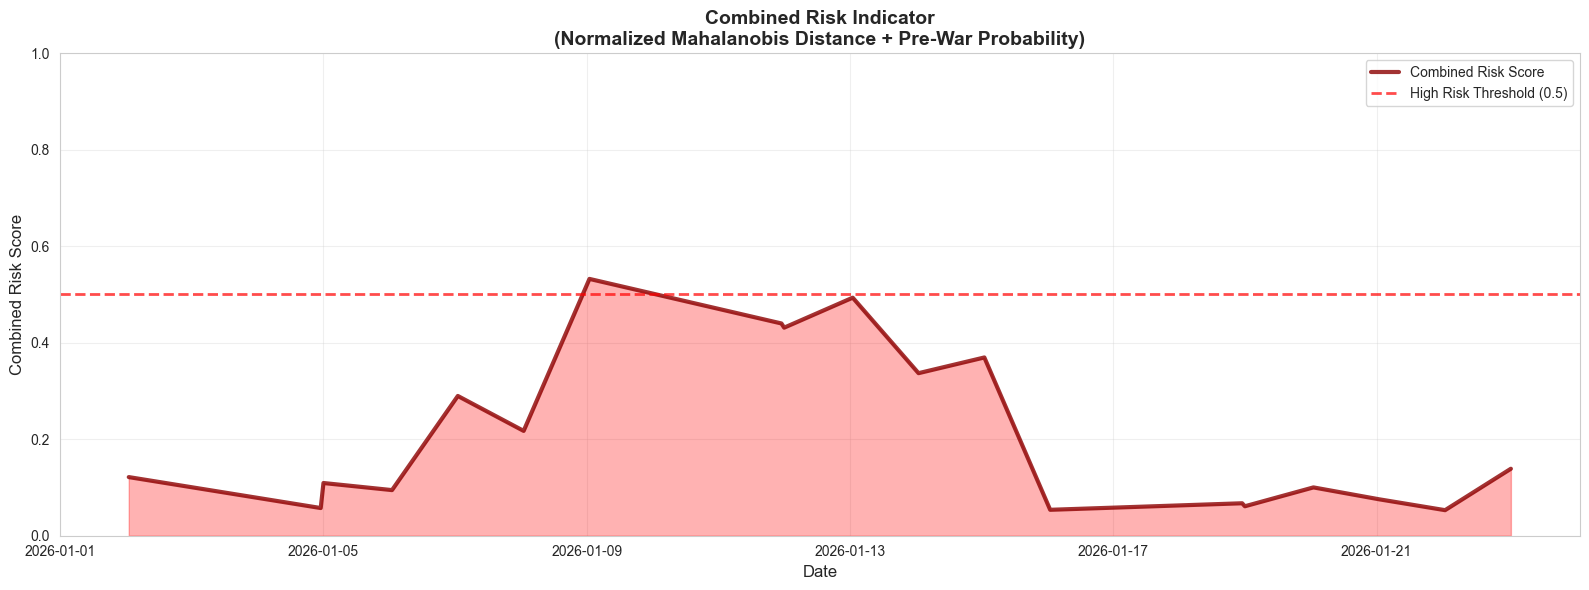


High Combined Risk Days (>0.5):
  2026-01-09: 0.5321 (Mahal: 5.35, Pre-War: 0.06)

MAHALANOBIS DISTANCE ANALYSIS COMPLETE

Mahalanobis distances stored in 'mahal_df' DataFrame
Combined risk assessment stored in 'combined_risk' DataFrame


In [8]:
# ============================================================================
# MAHALANOBIS DISTANCE: ANOMALY DETECTION AND RISK INDICATOR
# ============================================================================

print(f"{'='*80}")
print("MAHALANOBIS DISTANCE ANALYSIS")
print(f"{'='*80}")

# Mahalanobis distance measures how far a point is from the "normal" distribution
# Higher distance = more anomalous/unusual data point
# 
# IMPORTANT: We use only "Normal" labeled data (or Normal + Post-War Late) as baseline
# This gives a better measure of anomaly - comparing against stable periods, not all periods

# Option 1: Use only "Normal" periods
# Option 2: Use "Normal" + "Post-War Late" (both stable periods)
use_stable_periods_only = True  # Set to True to use only Normal + Post-War Late
include_post_war_late = True    # Set to True to include Post-War Late with Normal

if use_stable_periods_only:
    if include_post_war_late:
        # Use Normal + Post-War Late as baseline (stable periods)
        normal_mask = (df_train['label'] == 'Normal') | (df_train['label'] == 'Post-War Late')
        baseline_label = "Normal + Post-War Late (stable periods)"
    else:
        # Use only Normal periods as baseline
        normal_mask = df_train['label'] == 'Normal'
        baseline_label = "Normal periods only"
    
    X_train_normal = df_train[normal_mask][zscore_global_features].values
    print(f"\nUsing {baseline_label} for Mahalanobis distance baseline")
    print(f"  Baseline samples: {len(X_train_normal)} / {len(X_train)} total training samples")
    print(f"  Baseline labels: {df_train[normal_mask]['label'].value_counts().to_dict()}")
    
    # Calculate mean and covariance from stable periods only
    train_mean = np.mean(X_train_normal, axis=0)
    train_cov = np.cov(X_train_normal.T)
else:
    # Use all training data (original approach)
    print(f"\nUsing ALL training data for Mahalanobis distance baseline")
    print(f"  This includes all periods: {df_train['label'].value_counts().to_dict()}")
    train_mean = np.mean(X_train, axis=0)
    train_cov = np.cov(X_train.T)

# Handle potential singular matrix (add small regularization if needed)
try:
    train_cov_inv = inv(train_cov)
except np.linalg.LinAlgError:
    # If matrix is singular, add small regularization
    print("Warning: Covariance matrix is singular. Adding regularization...")
    train_cov_inv = inv(train_cov + np.eye(train_cov.shape[0]) * 1e-6)

# Calculate Mahalanobis distance for each test point
# Mahalanobis distance: sqrt((x - μ)' * Σ^(-1) * (x - μ))
mahalanobis_distances = []

for i in range(len(X_test)):
    test_point = X_test[i]
    try:
        # Calculate difference from mean
        diff = test_point - train_mean
        # Calculate Mahalanobis distance: sqrt(diff^T * cov_inv * diff)
        dist = np.sqrt(diff.T @ train_cov_inv @ diff)
        mahalanobis_distances.append(dist)
    except Exception as e:
        # Fallback: use Euclidean distance if Mahalanobis fails
        dist = np.linalg.norm(test_point - train_mean)
        mahalanobis_distances.append(dist)

mahalanobis_distances = np.array(mahalanobis_distances)

# Create DataFrame with Mahalanobis distances
mahal_df = df_test[test_valid_mask].copy()
mahal_df['mahalanobis_distance'] = mahalanobis_distances

# Calculate statistics
print(f"\nMahalanobis Distance Statistics:")
print(f"  Mean distance: {mahalanobis_distances.mean():.4f}")
print(f"  Median distance: {np.median(mahalanobis_distances):.4f}")
print(f"  Std distance: {mahalanobis_distances.std():.4f}")
print(f"  Min distance: {mahalanobis_distances.min():.4f}")
print(f"  Max distance: {mahalanobis_distances.max():.4f}")

# Calculate threshold based on baseline data (e.g., 95th percentile)
# Use the same baseline data (Normal or Normal + Post-War Late) for threshold calculation
if use_stable_periods_only:
    baseline_data = X_train_normal
else:
    baseline_data = X_train

train_mahal_distances = []
for i in range(len(baseline_data)):
    train_point = baseline_data[i]
    try:
        # Calculate difference from mean
        diff = train_point - train_mean
        # Calculate Mahalanobis distance
        dist = np.sqrt(diff.T @ train_cov_inv @ diff)
        train_mahal_distances.append(dist)
    except:
        dist = np.linalg.norm(train_point - train_mean)
        train_mahal_distances.append(dist)

train_mahal_distances = np.array(train_mahal_distances)
threshold_95 = np.percentile(train_mahal_distances, 95)
threshold_99 = np.percentile(train_mahal_distances, 99)

print(f"\nTraining Data Thresholds:")
print(f"  95th percentile: {threshold_95:.4f}")
print(f"  99th percentile: {threshold_99:.4f}")

print(f"\nTest Data Anomaly Detection:")
print(f"  Points above 95th percentile: {(mahalanobis_distances > threshold_95).sum()} / {len(mahalanobis_distances)} ({(mahalanobis_distances > threshold_95).sum()/len(mahalanobis_distances)*100:.1f}%)")
print(f"  Points above 99th percentile: {(mahalanobis_distances > threshold_99).sum()} / {len(mahalanobis_distances)} ({(mahalanobis_distances > threshold_99).sum()/len(mahalanobis_distances)*100:.1f}%)")

# Visualize Mahalanobis distance
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Mahalanobis distance over time
ax = axes[0]
ax.plot(mahal_df['date'], mahal_df['mahalanobis_distance'], 
       linewidth=2, color='darkblue', alpha=0.8, label='Mahalanobis Distance')
ax.fill_between(mahal_df['date'], 0, mahal_df['mahalanobis_distance'], 
               alpha=0.3, color='blue')

ax.axhline(y=threshold_95, color='orange', linestyle='--', linewidth=2, 
          label=f'95th Percentile Threshold ({threshold_95:.2f})', alpha=0.7)
ax.axhline(y=threshold_99, color='red', linestyle='--', linewidth=2, 
          label=f'99th Percentile Threshold ({threshold_99:.2f})', alpha=0.7)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Mahalanobis Distance', fontsize=12)
baseline_title = baseline_label if use_stable_periods_only else "All Training Data"
ax.set_title(f'Mahalanobis Distance Over Time\n(Measure of Anomaly from {baseline_title})', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Highlight anomalous points
anomalous_mask = mahal_df['mahalanobis_distance'] > threshold_95
if anomalous_mask.any():
    ax.scatter(mahal_df.loc[anomalous_mask, 'date'], 
              mahal_df.loc[anomalous_mask, 'mahalanobis_distance'],
              color='red', s=100, marker='x', linewidth=3, 
              label='Anomalous Points (>95th percentile)', zorder=5)

# Plot 2: Mahalanobis distance vs Pre-War Risk
ax = axes[1]
if 'max_pre_war_probability' in risk_df.columns:
    # Align dates - normalize timezone for merging (convert both to timezone-naive)
    mahal_temp = mahal_df.copy()
    mahal_date_conv = pd.to_datetime(mahal_temp['date'])
    # Remove timezone if present, otherwise keep as is
    if mahal_date_conv.dt.tz is not None:
        mahal_temp['date_merge'] = mahal_date_conv.dt.tz_localize(None)
    else:
        mahal_temp['date_merge'] = mahal_date_conv
    
    risk_temp = risk_df[['date', 'max_pre_war_probability']].copy()
    risk_date_conv = pd.to_datetime(risk_temp['date'])
    # Remove timezone if present, otherwise keep as is
    if risk_date_conv.dt.tz is not None:
        risk_temp['date_merge'] = risk_date_conv.dt.tz_localize(None)
    else:
        risk_temp['date_merge'] = risk_date_conv
    
    # Merge on normalized dates
    merged_df = mahal_temp.merge(risk_temp[['date_merge', 'max_pre_war_probability']], 
                               left_on='date_merge', right_on='date_merge', how='inner')
    
    scatter = ax.scatter(merged_df['mahalanobis_distance'], 
                        merged_df['max_pre_war_probability'],
                        c=merged_df['date'], cmap='viridis', 
                        s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Mahalanobis Distance', fontsize=12)
    ax.set_ylabel('Maximum Pre-War Probability', fontsize=12)
    ax.set_title('Mahalanobis Distance vs Pre-War Risk\n(Anomaly Detection vs Geopolitical Risk)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Date', fontsize=10)
    
    # Add threshold lines
    ax.axvline(x=threshold_95, color='orange', linestyle='--', alpha=0.5, 
              label=f'95th Percentile Distance ({threshold_95:.2f})')
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, 
              label='High Pre-War Risk (0.5)')
    
    ax.legend(loc='best', fontsize=9)
else:
    ax.text(0.5, 0.5, 'Pre-war risk data not available', 
           ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Mahalanobis Distance vs Pre-War Risk', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# COMPARISON: PRE-WAR PERIODS vs CURRENT DATA
# ============================================================================

print(f"\n{'─'*80}")
print("PRE-WAR PERIODS MAHALANOBIS DISTANCE ANALYSIS")
print(f"{'─'*80}")

# Calculate Mahalanobis distances for pre-war periods in training data
pre_war_early_mask = df_train['label'] == 'Pre-War Early'
pre_war_close_mask = df_train['label'] == 'Pre-War Close'

pre_war_early_data = df_train[pre_war_early_mask][zscore_global_features].values
pre_war_close_data = df_train[pre_war_close_mask][zscore_global_features].values

pre_war_early_dates = df_train[pre_war_early_mask]['date'].values
pre_war_close_dates = df_train[pre_war_close_mask]['date'].values

# Calculate Mahalanobis distances for pre-war periods
pre_war_early_mahal = []
for i in range(len(pre_war_early_data)):
    point = pre_war_early_data[i]
    try:
        diff = point - train_mean
        dist = np.sqrt(diff.T @ train_cov_inv @ diff)
        pre_war_early_mahal.append(dist)
    except:
        dist = np.linalg.norm(point - train_mean)
        pre_war_early_mahal.append(dist)

pre_war_close_mahal = []
for i in range(len(pre_war_close_data)):
    point = pre_war_close_data[i]
    try:
        diff = point - train_mean
        dist = np.sqrt(diff.T @ train_cov_inv @ diff)
        pre_war_close_mahal.append(dist)
    except:
        dist = np.linalg.norm(point - train_mean)
        pre_war_close_mahal.append(dist)

pre_war_early_mahal = np.array(pre_war_early_mahal)
pre_war_close_mahal = np.array(pre_war_close_mahal)

print(f"\nPre-War Period Statistics:")
print(f"  Pre-War Early:")
print(f"    Count: {len(pre_war_early_mahal)} days")
print(f"    Mean Mahalanobis distance: {pre_war_early_mahal.mean():.4f}")
print(f"    Max Mahalanobis distance: {pre_war_early_mahal.max():.4f}")
print(f"    Days above 95th percentile: {(pre_war_early_mahal > threshold_95).sum()} / {len(pre_war_early_mahal)}")
print(f"  Pre-War Close:")
print(f"    Count: {len(pre_war_close_mahal)} days")
print(f"    Mean Mahalanobis distance: {pre_war_close_mahal.mean():.4f}")
print(f"    Max Mahalanobis distance: {pre_war_close_mahal.max():.4f}")
print(f"    Days above 95th percentile: {(pre_war_close_mahal > threshold_95).sum()} / {len(pre_war_close_mahal)}")
print(f"\nCurrent Data (2026) Statistics:")
print(f"    Count: {len(mahalanobis_distances)} days")
print(f"    Mean Mahalanobis distance: {mahalanobis_distances.mean():.4f}")
print(f"    Max Mahalanobis distance: {mahalanobis_distances.max():.4f}")
print(f"    Days above 95th percentile: {(mahalanobis_distances > threshold_95).sum()} / {len(mahalanobis_distances)}")

# Create comparison visualization with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Side-by-side box plot comparison
ax = axes[0]
box_data = [pre_war_early_mahal, pre_war_close_mahal, mahalanobis_distances]
box_labels = ['Pre-War\nEarly', 'Pre-War\nClose', 'Current\n(2026)']
bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True, 
                showmeans=True, meanline=True)

# Color the boxes
colors = ['lightblue', 'orange', 'darkblue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add threshold lines
ax.axhline(y=threshold_95, color='red', linestyle='--', linewidth=2, 
          label=f'95th Percentile ({threshold_95:.2f})', alpha=0.7)
ax.axhline(y=threshold_99, color='darkred', linestyle='--', linewidth=2, 
          label=f'99th Percentile ({threshold_99:.2f})', alpha=0.7)

ax.set_ylabel('Mahalanobis Distance', fontsize=12)
ax.set_title('Mahalanobis Distance Comparison\n(Pre-War Periods vs Current Data)', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Pre-War Periods (Historical)
ax2 = axes[1]

# Convert dates to datetime and normalize timezone
pre_war_early_dates_conv = pd.to_datetime(pre_war_early_dates)
if hasattr(pre_war_early_dates_conv, 'dt') and pre_war_early_dates_conv.dt.tz is not None:
    pre_war_early_dates_conv = pre_war_early_dates_conv.dt.tz_localize(None)

pre_war_close_dates_conv = pd.to_datetime(pre_war_close_dates)
if hasattr(pre_war_close_dates_conv, 'dt') and pre_war_close_dates_conv.dt.tz is not None:
    pre_war_close_dates_conv = pre_war_close_dates_conv.dt.tz_localize(None)

# Plot pre-war early
if len(pre_war_early_dates) > 0:
    ax2.scatter(pre_war_early_dates_conv, pre_war_early_mahal, 
              color='lightblue', s=100, alpha=0.7, label='Pre-War Early', 
              edgecolors='blue', linewidth=1.5, zorder=3, marker='s')

# Plot pre-war close
if len(pre_war_close_dates) > 0:
    ax2.scatter(pre_war_close_dates_conv, pre_war_close_mahal, 
              color='orange', s=100, alpha=0.7, label='Pre-War Close', 
              edgecolors='darkorange', linewidth=1.5, zorder=3, marker='^')

# Add threshold lines
ax2.axhline(y=threshold_95, color='red', linestyle='--', linewidth=2, 
          label=f'95th Percentile ({threshold_95:.2f})', alpha=0.7, zorder=1)
ax2.axhline(y=threshold_99, color='darkred', linestyle='--', linewidth=2, 
          label=f'99th Percentile ({threshold_99:.2f})', alpha=0.7, zorder=1)

# Set x-axis limits for pre-war periods
if len(pre_war_early_dates_conv) > 0 or len(pre_war_close_dates_conv) > 0:
    pre_war_dates_all = []
    if len(pre_war_early_dates_conv) > 0:
        pre_war_dates_all.extend(pre_war_early_dates_conv.tolist())
    if len(pre_war_close_dates_conv) > 0:
        pre_war_dates_all.extend(pre_war_close_dates_conv.tolist())
    
    if len(pre_war_dates_all) > 0:
        date_min = min(pre_war_dates_all)
        date_max = max(pre_war_dates_all)
        padding = pd.Timedelta(days=(date_max - date_min).days * 0.1)
        ax2.set_xlim([date_min - padding, date_max + padding])

ax2.set_xlabel('Date (Historical Pre-War Periods)', fontsize=12)
ax2.set_ylabel('Mahalanobis Distance', fontsize=12)
ax2.set_title('Pre-War Periods: Mahalanobis Distance\n(Historical Data: 2024-2025)', 
            fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Current Data (2026)
ax3 = axes[2]

current_dates_conv = pd.to_datetime(mahal_df['date'])
if hasattr(current_dates_conv, 'dt') and current_dates_conv.dt.tz is not None:
    current_dates_conv = current_dates_conv.dt.tz_localize(None)

# Plot current data (2026)
ax3.plot(current_dates_conv, mahal_df['mahalanobis_distance'], 
       linewidth=2.5, color='darkblue', alpha=0.9, label='Current (2026)', 
       marker='o', markersize=8, zorder=4)

# Add threshold lines
ax3.axhline(y=threshold_95, color='red', linestyle='--', linewidth=2, 
          label=f'95th Percentile ({threshold_95:.2f})', alpha=0.7, zorder=1)
ax3.axhline(y=threshold_99, color='darkred', linestyle='--', linewidth=2, 
          label=f'99th Percentile ({threshold_99:.2f})', alpha=0.7, zorder=1)

# Set x-axis limits for current data
if len(current_dates_conv) > 0:
    date_min = min(current_dates_conv)
    date_max = max(current_dates_conv)
    padding = pd.Timedelta(days=(date_max - date_min).days * 0.1)
    ax3.set_xlim([date_min - padding, date_max + padding])

ax3.set_xlabel('Date (Current Data)', fontsize=12)
ax3.set_ylabel('Mahalanobis Distance', fontsize=12)
ax3.set_title('Current Data: Mahalanobis Distance\n(Test Period: 2026)', 
            fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Set same y-axis limits for all plots for easy comparison
all_mahal_values = []
all_mahal_values.extend(pre_war_early_mahal.tolist())
all_mahal_values.extend(pre_war_close_mahal.tolist())
all_mahal_values.extend(mahalanobis_distances.tolist())
if len(all_mahal_values) > 0:
    y_min = min(all_mahal_values) * 0.9
    y_max = max(all_mahal_values) * 1.1
    ax.set_ylim([y_min, y_max])
    ax2.set_ylim([y_min, y_max])
    ax3.set_ylim([y_min, y_max])

plt.tight_layout()
plt.show()

# Statistical comparison
print(f"\n{'─'*80}")
print("STATISTICAL COMPARISON")
print(f"{'─'*80}")
print(f"Current (2026) vs Pre-War Early:")
print(f"  Mean difference: {mahalanobis_distances.mean() - pre_war_early_mahal.mean():.4f}")
print(f"  Current mean is {'higher' if mahalanobis_distances.mean() > pre_war_early_mahal.mean() else 'lower'} than Pre-War Early")
print(f"\nCurrent (2026) vs Pre-War Close:")
print(f"  Mean difference: {mahalanobis_distances.mean() - pre_war_close_mahal.mean():.4f}")
print(f"  Current mean is {'higher' if mahalanobis_distances.mean() > pre_war_close_mahal.mean() else 'lower'} than Pre-War Close")

# Display most anomalous days
print(f"\n{'─'*80}")
print("MOST ANOMALOUS DAYS (Highest Mahalanobis Distance):")
print(f"{'─'*80}")
top_anomalies = mahal_df.nlargest(5, 'mahalanobis_distance')[['date', 'mahalanobis_distance']]
for idx, row in top_anomalies.iterrows():
    is_anomalous = "⚠️ ANOMALOUS" if row['mahalanobis_distance'] > threshold_95 else ""
    print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['mahalanobis_distance']:.4f} {is_anomalous}")

# Combine Mahalanobis distance with risk assessment
print(f"\n{'='*80}")
print("COMBINED RISK ASSESSMENT")
print(f"{'='*80}")

if 'max_pre_war_probability' in risk_df.columns:
    # Merge Mahalanobis distance with pre-war risk - normalize timezone for merging
    mahal_temp = mahal_df.copy()
    mahal_date_conv = pd.to_datetime(mahal_temp['date'])
    # Remove timezone if present, otherwise keep as is
    if mahal_date_conv.dt.tz is not None:
        mahal_temp['date_merge'] = mahal_date_conv.dt.tz_localize(None)
    else:
        mahal_temp['date_merge'] = mahal_date_conv
    
    risk_temp = risk_df[['date', 'max_pre_war_probability']].copy()
    risk_date_conv = pd.to_datetime(risk_temp['date'])
    # Remove timezone if present, otherwise keep as is
    if risk_date_conv.dt.tz is not None:
        risk_temp['date_merge'] = risk_date_conv.dt.tz_localize(None)
    else:
        risk_temp['date_merge'] = risk_date_conv
    
    # Merge on normalized dates
    combined_risk = mahal_temp.merge(risk_temp[['date_merge', 'max_pre_war_probability']], 
                                   left_on='date_merge', right_on='date_merge', how='inner')
    
    # Normalize Mahalanobis distance to 0-1 scale for comparison
    mahal_normalized = (combined_risk['mahalanobis_distance'] - combined_risk['mahalanobis_distance'].min()) / \
                      (combined_risk['mahalanobis_distance'].max() - combined_risk['mahalanobis_distance'].min())
    
    # Combined risk score (average of normalized Mahalanobis and pre-war probability)
    combined_risk['combined_risk_score'] = (mahal_normalized + combined_risk['max_pre_war_probability']) / 2
    
    print(f"\nCombined Risk Score Statistics:")
    print(f"  Mean: {combined_risk['combined_risk_score'].mean():.4f}")
    print(f"  Max: {combined_risk['combined_risk_score'].max():.4f}")
    print(f"  Days with combined risk > 0.5: {(combined_risk['combined_risk_score'] > 0.5).sum()} / {len(combined_risk)}")
    
    # Visualize combined risk
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(combined_risk['date'], combined_risk['combined_risk_score'], 
           linewidth=3, color='darkred', alpha=0.8, label='Combined Risk Score')
    ax.fill_between(combined_risk['date'], 0, combined_risk['combined_risk_score'], 
                    alpha=0.3, color='red')
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
              label='High Risk Threshold (0.5)', alpha=0.7)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Combined Risk Score', fontsize=12)
    ax.set_title('Combined Risk Indicator\n(Normalized Mahalanobis Distance + Pre-War Probability)', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()
    
    print(f"\nHigh Combined Risk Days (>0.5):")
    high_combined_risk = combined_risk[combined_risk['combined_risk_score'] > 0.5].sort_values('combined_risk_score', ascending=False)
    if len(high_combined_risk) > 0:
        for idx, row in high_combined_risk.iterrows():
            print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['combined_risk_score']:.4f} "
                  f"(Mahal: {row['mahalanobis_distance']:.2f}, Pre-War: {row['max_pre_war_probability']:.2f})")
    else:
        print("  No days with combined risk > 0.5")

print(f"\n{'='*80}")
print("MAHALANOBIS DISTANCE ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"\nMahalanobis distances stored in 'mahal_df' DataFrame")
if 'combined_risk' in locals():
    print(f"Combined risk assessment stored in 'combined_risk' DataFrame")

ADDITIONAL INSIGHTS ANALYSIS

────────────────────────────────────────────────────────────────────────────────
MODEL AGREEMENT ANALYSIS
────────────────────────────────────────────────────────────────────────────────

Model Agreement Statistics:
  Total days analyzed: 19
  Average agreement: 100.0%
  Days with 100% agreement: 19 / 19
  Days with disagreement: 0 / 19


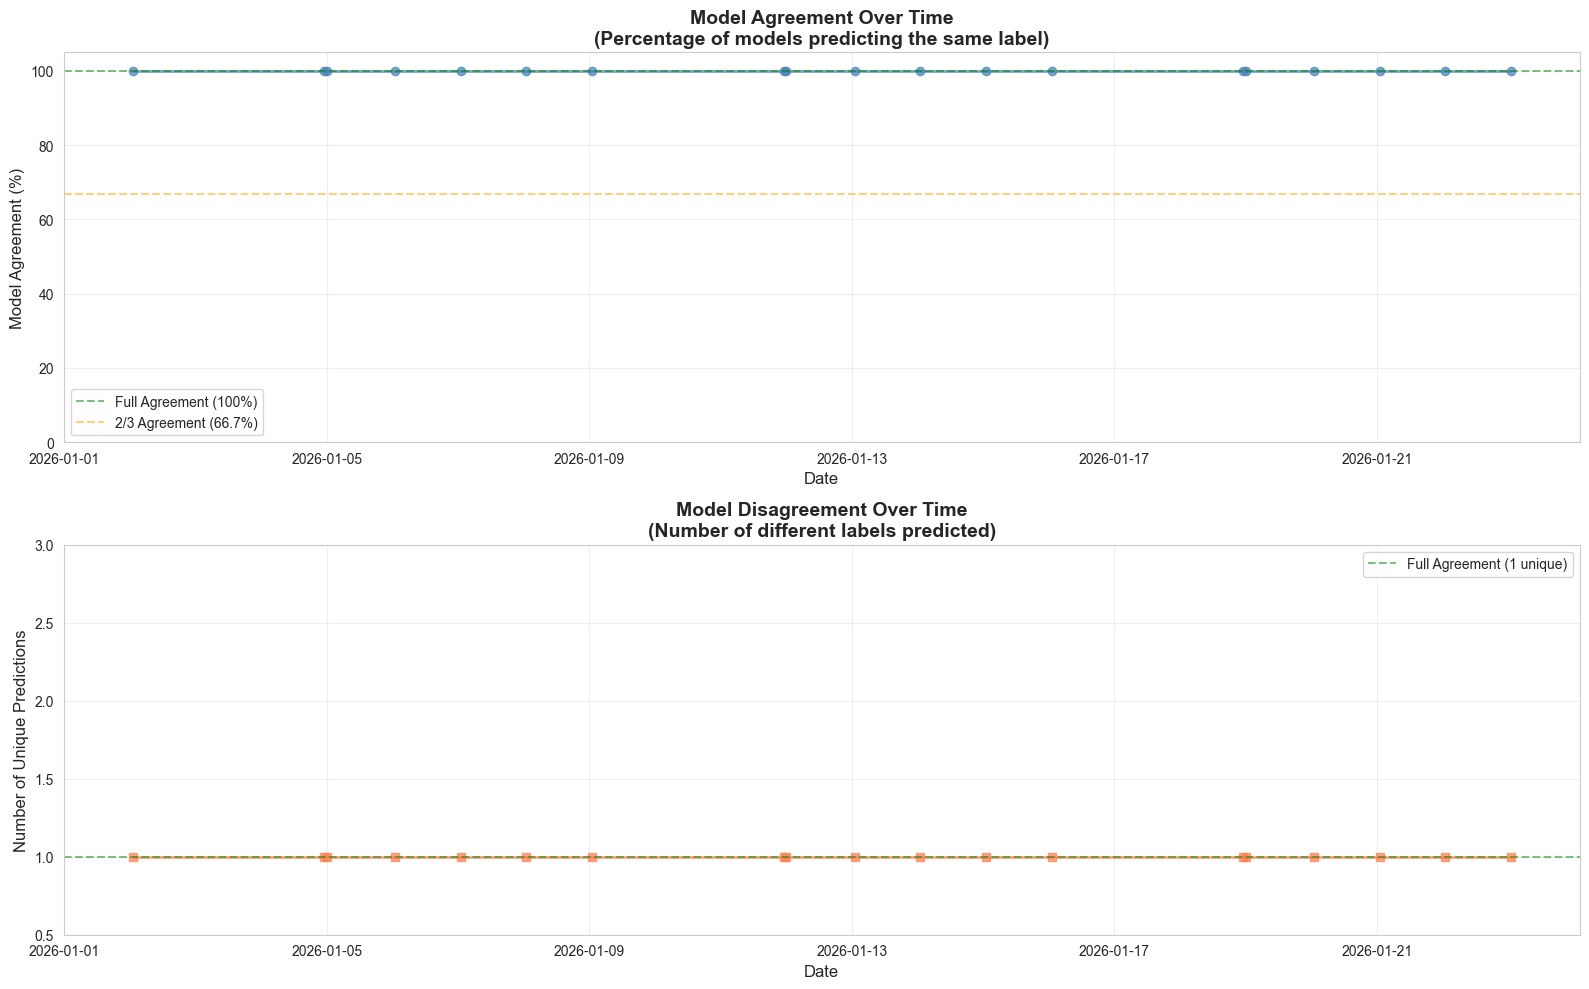


────────────────────────────────────────────────────────────────────────────────
FEATURE CONTRIBUTION TO MAHALANOBIS DISTANCE
────────────────────────────────────────────────────────────────────────────────

Analyzing top 5 most anomalous days:

  2026-01-09 (Mahal Distance: 5.35):
    - WTI_return_1d_zscore_global: value=2.13, deviation=2.13
    - spread_vol_5d_zscore_global: value=2.21, deviation=2.16
    - WTI_price_vol_30d_zscore_global: value=-1.45, deviation=1.31

  2026-01-13 (Mahal Distance: 5.12):
    - WTI_return_5d_zscore_global: value=1.98, deviation=1.98
    - spread_vol_5d_zscore_global: value=2.33, deviation=2.28
    - WTI_return_1d_zscore_global: value=1.70, deviation=1.70

  2026-01-11 (Mahal Distance: 4.84):
    - spread_vol_5d_zscore_global: value=2.54, deviation=2.49
    - WTI_price_vol_30d_zscore_global: value=-1.46, deviation=1.32
    - WTI_return_1d_zscore_global: value=1.26, deviation=1.26

  2026-01-12 (Mahal Distance: 4.76):
    - spread_vol_5d_zscore_global:

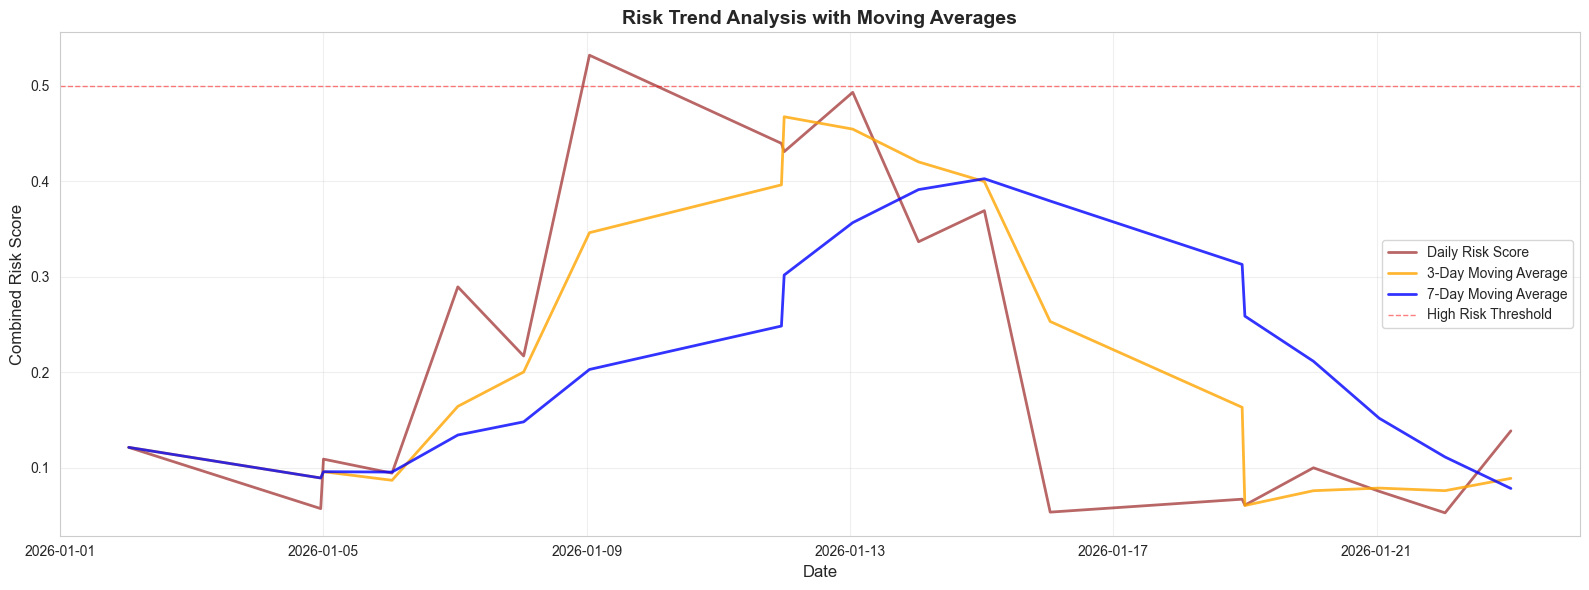


────────────────────────────────────────────────────────────────────────────────
CORRELATION BETWEEN RISK INDICATORS
────────────────────────────────────────────────────────────────────────────────

Correlation Matrix:
                         mahalanobis_normalized  max_pre_war_probability  combined_risk_score
mahalanobis_normalized                    1.000                   -0.234                0.989
max_pre_war_probability                  -0.234                    1.000               -0.085
combined_risk_score                       0.989                   -0.085                1.000


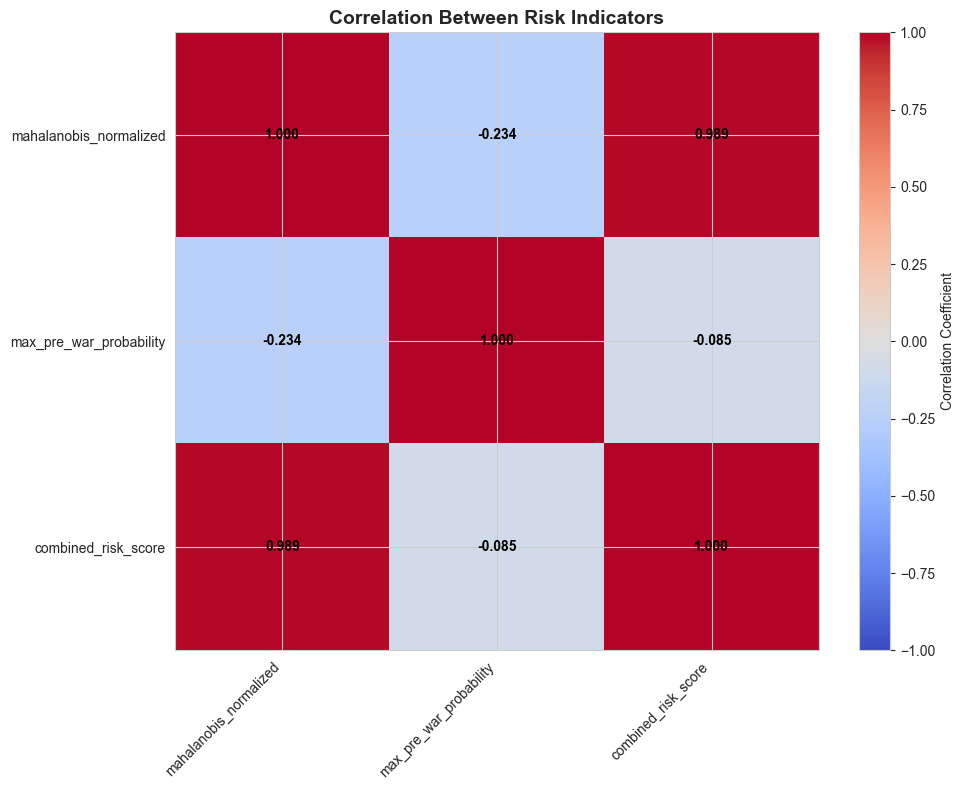


Interpretation:
  - Mahalanobis (normalized) vs Pre-War Risk: -0.234
    (Negative correlation: Anomalies and pre-war predictions are independent/opposite)

ADDITIONAL INSIGHTS ANALYSIS COMPLETE


In [9]:
# ============================================================================
# ADDITIONAL INSIGHTS: MODEL AGREEMENT & FEATURE CONTRIBUTION
# ============================================================================

print(f"{'='*80}")
print("ADDITIONAL INSIGHTS ANALYSIS")
print(f"{'='*80}")

# ============================================================================
# 1. MODEL AGREEMENT ANALYSIS
# ============================================================================

print(f"\n{'─'*80}")
print("MODEL AGREEMENT ANALYSIS")
print(f"{'─'*80}")

# Check how often models agree on predictions
# Use index-based matching since all models should have same dates in same order
agreement_data = []

# Get dates from first model
first_model_name = list(all_predictions.keys())[0]
first_model_df = all_predictions[first_model_name].sort_values('date').reset_index(drop=True)

# Iterate through each row (each date)
for idx in range(len(first_model_df)):
    date = first_model_df.loc[idx, 'date']
    predictions_for_date = []
    
    # Get prediction from each model for this index position
    for model_name in all_predictions.keys():
        model_df = all_predictions[model_name].sort_values('date').reset_index(drop=True)
        if idx < len(model_df):
            pred = model_df.loc[idx, 'predicted_label']
            predictions_for_date.append(pred)
    
    if len(predictions_for_date) > 0:
        # Count unique predictions
        unique_preds = len(set(predictions_for_date))
        most_common = max(set(predictions_for_date), key=predictions_for_date.count)
        agreement_pct = predictions_for_date.count(most_common) / len(predictions_for_date) * 100
        
        agreement_data.append({
            'date': date,
            'num_models': len(predictions_for_date),
            'unique_predictions': unique_preds,
            'agreement_pct': agreement_pct,
            'most_common_pred': most_common
        })

agreement_df = pd.DataFrame(agreement_data)

# Check if DataFrame is empty or has no data
if len(agreement_df) == 0:
    print(f"\n⚠️  Warning: No agreement data found. Check date matching between models.")
    print(f"   First model dates: {len(first_model_df)} dates")
    print(f"   Models available: {list(all_predictions.keys())}")
else:
    print(f"\nModel Agreement Statistics:")
    print(f"  Total days analyzed: {len(agreement_df)}")
    print(f"  Average agreement: {agreement_df['agreement_pct'].mean():.1f}%")
    print(f"  Days with 100% agreement: {(agreement_df['agreement_pct'] == 100).sum()} / {len(agreement_df)}")
    print(f"  Days with disagreement: {(agreement_df['unique_predictions'] > 1).sum()} / {len(agreement_df)}")

if len(agreement_df) > 0:
    if (agreement_df['unique_predictions'] > 1).any():
        print(f"\nDays with model disagreement:")
        disagreements = agreement_df[agreement_df['unique_predictions'] > 1].sort_values('date')
        for idx, row in disagreements.iterrows():
            date_str = row['date'].strftime('%Y-%m-%d') if hasattr(row['date'], 'strftime') else str(row['date'])
            print(f"  {date_str}: {row['unique_predictions']} different predictions, {row['agreement_pct']:.0f}% agreement")

# Visualize agreement (only if we have data)
if len(agreement_df) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
else:
    print(f"\n⚠️  Skipping visualizations - no agreement data available")
    fig, axes = None, None

if fig is not None and axes is not None:
    # Plot 1: Agreement percentage over time
    ax = axes[0]
    ax.plot(agreement_df['date'], agreement_df['agreement_pct'], 
           marker='o', linewidth=2, markersize=6, color='steelblue', alpha=0.7)
    ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Full Agreement (100%)')
    ax.axhline(y=66.7, color='orange', linestyle='--', alpha=0.5, label='2/3 Agreement (66.7%)')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Model Agreement (%)', fontsize=12)
    ax.set_title('Model Agreement Over Time\n(Percentage of models predicting the same label)', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 105])

    # Plot 2: Number of unique predictions
    ax = axes[1]
    ax.plot(agreement_df['date'], agreement_df['unique_predictions'], 
           marker='s', linewidth=2, markersize=6, color='coral', alpha=0.7)
    ax.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Full Agreement (1 unique)')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Number of Unique Predictions', fontsize=12)
    ax.set_title('Model Disagreement Over Time\n(Number of different labels predicted)', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.5, max(3, agreement_df['unique_predictions'].max() + 0.5)])

    plt.tight_layout()
    plt.show()

# ============================================================================
# 2. FEATURE CONTRIBUTION TO ANOMALIES
# ============================================================================

print(f"\n{'─'*80}")
print("FEATURE CONTRIBUTION TO MAHALANOBIS DISTANCE")
print(f"{'─'*80}")

# For high-anomaly days, identify which features contribute most
if len(mahal_df) > 0:
    # Get top 5 most anomalous days
    top_anomalies = mahal_df.nlargest(5, 'mahalanobis_distance')
    
    print(f"\nAnalyzing top 5 most anomalous days:")
    
    feature_contributions = []
    for idx, row in top_anomalies.iterrows():
        date = row['date']
        # Get feature values for this date
        date_mask = df_test[test_valid_mask]['date'] == date
        if date_mask.any():
            features_for_date = df_test[test_valid_mask].loc[date_mask, zscore_global_features].iloc[0]
            
            # Calculate contribution: (feature - mean) / std for each feature
            # Higher absolute deviation = more contribution to anomaly
            deviations = np.abs(features_for_date.values - train_mean)
            # Normalize by feature std (from covariance matrix diagonal)
            feature_stds = np.sqrt(np.diag(train_cov))
            normalized_deviations = deviations / (feature_stds + 1e-10)  # Add small epsilon to avoid division by zero
            
            # Get top contributing features
            top_indices = np.argsort(normalized_deviations)[-3:][::-1]  # Top 3
            
            print(f"\n  {date.strftime('%Y-%m-%d')} (Mahal Distance: {row['mahalanobis_distance']:.2f}):")
            for feat_idx in top_indices:
                feat_name = zscore_global_features[feat_idx]
                feat_value = features_for_date.iloc[feat_idx]
                deviation = deviations[feat_idx]
                print(f"    - {feat_name}: value={feat_value:.2f}, deviation={deviation:.2f}")

# ============================================================================
# 3. RISK TREND ANALYSIS
# ============================================================================

print(f"\n{'─'*80}")
print("RISK TREND ANALYSIS")
print(f"{'─'*80}")

if 'combined_risk' in locals() and 'combined_risk_score' in combined_risk.columns:
    # Calculate rolling statistics
    combined_risk_sorted = combined_risk.sort_values('date').copy()
    combined_risk_sorted['risk_ma_3d'] = combined_risk_sorted['combined_risk_score'].rolling(window=3, min_periods=1).mean()
    combined_risk_sorted['risk_ma_7d'] = combined_risk_sorted['combined_risk_score'].rolling(window=7, min_periods=1).mean()
    
    # Trend direction
    combined_risk_sorted['risk_trend'] = combined_risk_sorted['combined_risk_score'].diff()
    
    print(f"\nRisk Trend Statistics:")
    print(f"  Current risk: {combined_risk_sorted['combined_risk_score'].iloc[-1]:.4f}")
    print(f"  3-day average: {combined_risk_sorted['risk_ma_3d'].iloc[-1]:.4f}")
    print(f"  7-day average: {combined_risk_sorted['risk_ma_7d'].iloc[-1]:.4f}")
    print(f"  Recent trend (last 3 days): {combined_risk_sorted['risk_trend'].tail(3).mean():.4f} ({'↑ Increasing' if combined_risk_sorted['risk_trend'].tail(3).mean() > 0 else '↓ Decreasing'})")
    
    # Visualize trends
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(combined_risk_sorted['date'], combined_risk_sorted['combined_risk_score'], 
           linewidth=2, color='darkred', alpha=0.6, label='Daily Risk Score')
    ax.plot(combined_risk_sorted['date'], combined_risk_sorted['risk_ma_3d'], 
           linewidth=2, color='orange', alpha=0.8, label='3-Day Moving Average')
    ax.plot(combined_risk_sorted['date'], combined_risk_sorted['risk_ma_7d'], 
           linewidth=2, color='blue', alpha=0.8, label='7-Day Moving Average')
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='High Risk Threshold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Combined Risk Score', fontsize=12)
    ax.set_title('Risk Trend Analysis with Moving Averages', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 4. CORRELATION BETWEEN RISK INDICATORS
# ============================================================================

print(f"\n{'─'*80}")
print("CORRELATION BETWEEN RISK INDICATORS")
print(f"{'─'*80}")

if 'combined_risk' in locals():
    # Merge all risk indicators
    risk_corr_df = combined_risk[['mahalanobis_distance', 'max_pre_war_probability', 'combined_risk_score']].copy()
    
    # Normalize Mahalanobis for correlation (use same normalization as in combined risk)
    mahal_normalized = (risk_corr_df['mahalanobis_distance'] - risk_corr_df['mahalanobis_distance'].min()) / \
                      (risk_corr_df['mahalanobis_distance'].max() - risk_corr_df['mahalanobis_distance'].min())
    risk_corr_df['mahalanobis_normalized'] = mahal_normalized
    
    # Calculate correlations
    corr_matrix = risk_corr_df[['mahalanobis_normalized', 'max_pre_war_probability', 'combined_risk_score']].corr()
    
    print(f"\nCorrelation Matrix:")
    print(corr_matrix.round(3).to_string())
    
    # Visualize correlation
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr_matrix.values, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.columns)
    ax.set_title('Correlation Between Risk Indicators', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.3f}',
                         ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Correlation Coefficient')
    plt.tight_layout()
    plt.show()
    
    print(f"\nInterpretation:")
    print(f"  - Mahalanobis (normalized) vs Pre-War Risk: {corr_matrix.loc['mahalanobis_normalized', 'max_pre_war_probability']:.3f}")
    print(f"    ({'Positive' if corr_matrix.loc['mahalanobis_normalized', 'max_pre_war_probability'] > 0 else 'Negative'} correlation: {'Anomalies tend to coincide with pre-war predictions' if corr_matrix.loc['mahalanobis_normalized', 'max_pre_war_probability'] > 0 else 'Anomalies and pre-war predictions are independent/opposite'})")

print(f"\n{'='*80}")
print("ADDITIONAL INSIGHTS ANALYSIS COMPLETE")
print(f"{'='*80}")